## 1. Frequency and Impact Analysis Setup

**Methods for Research Question 1**  

This section sets up our **Frequency** and **Citation (Impact) Analysis**. We:
1. Import core Python libraries (`pandas`, `numpy`, `matplotlib`, etc.).
2. Define constants like the start year (`START_YEAR`) and the path to our pickled data structures.
3. Prepare the set of years (2010–2021) that will be used in the subsequent analysis.

These steps lay the groundwork for measuring the annual volume of scientific papers or SBIR awards (frequency) as well as total citation or funding (impact) for each MeSH term.

In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests

PICKLES_ADDRESS = 'pickles/'
LAG_DATA_ADDRESS = '../lag_data/'
TEMP_ADDRESS = '../temp/'

## 2. Data Loading and Preprocessing  

Here, we load several pickled dictionaries that store:  
- **MeSH Hierarchy Info**: Parent-child relationships (`dui2children`), levels (`dui2level`), etc.  
- **Frequency Data**: The yearly counts of PubMed papers and SBIR grants for each MeSH term (`dui2pubfreq`, `dui2sbfreq`).  
- **Citation Data**: The total citations (for publications) and total funding (for SBIRs) used as impact scores (`dui2pubcit`, `dui2sbcit`).

We also filter out terms (`exduis`) that have zero frequency across the entire time window to focus the analysis on relevant topics.

In [5]:
years = [str(year) for year in range(2010, 2022)]
START_YEAR, START_YEAR_IDX, SF_TAG = 2010, 0, 'SF10'
correlation_lags = list(range(-11 + START_YEAR_IDX, 11 - (START_YEAR_IDX - 1)))
print('years:', years)
print('correlation_lags:', correlation_lags)

with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(TEMP_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(TEMP_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(TEMP_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(TEMP_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [6]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

len(exduis), c

(29307, 0)

In [8]:
# count how many excuis have False and True values
c = 0
for dui in exduis:
    if exduis[dui] == False:
        c += 1
print(c, 'DUIs remained.')

10873 DUIs remained.


100%|██████████| 12/12 [00:00<00:00, 14.98it/s]


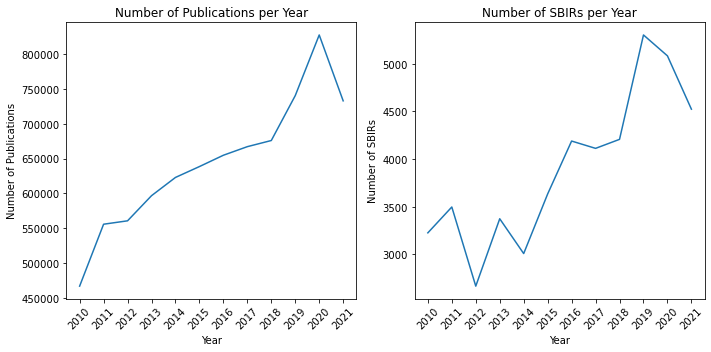

In [9]:
total_pubs_per_year = {}
for year in tqdm(years):
    pmids_list = []
    for dui in dui2pubcit:
        if not exduis[dui]:
            pmids_list += list(zip(dui2pubfreqchild[dui][year], dui2pubcitchild[dui][year]))
    pmids_set = set(pmids_list)
    # pmids_set = set([pmid for pmid in pmids_set if pmid[1] is not None])
    total_pubs_per_year[year] = np.sum([impact_score for _, impact_score in pmids_set])

total_sbirs_per_year = {}
for year in tqdm(years):
    sbids_list = []
    for dui in dui2sbfreq:
        if not exduis[dui]:
            sbids_list += list(zip(dui2sbfreqchild[dui][year], dui2sbcitchild[dui][year]))
    sbids_set = set(sbids_list)
    # sbids_set = set([sbid for sbid in sbids_set if sbid[1] is not None])
    total_sbirs_per_year[year] = np.sum([impact_score for _, impact_score in sbids_set])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_pubs_per_year.keys(), total_pubs_per_year.values())
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Publications')
axs[0].set_title('Number of Publications per Year')
axs[1].plot(total_sbirs_per_year.keys(), total_sbirs_per_year.values())
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of SBIRs')
axs[1].set_title('Number of SBIRs per Year')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

## 3. Frequency and Citation Signal Computation

**Frequency & Impact Representations**  

1. **Frequency Representation**  
   - We compute the annual proportion of PubMed papers or SBIR grants for each MeSH term compared to the total in that year.  
   - This aligns with Equations (1)–(3) in the paper, where we normalize to capture relative frequency.

2. **Citation (Impact) Representation**  
   - We sum the citation or funding “impact scores” per MeSH term and normalize relative to the total in that year.  
   - This corresponds to Equation (4), representing each term’s share of the citation/funding “budget.”

By computing these signals (`dui2pubCitSigProp` / `dui2sbCitSigProp`), we obtain time series that express how important or prominent a MeSH topic is year by year, both in quantity (frequency) and in significance (impact).

In [10]:
c = 0
dui2pubCitSigProp = {}
dui2sbCitSigProp = {}
for dui in tqdm(dui2pubcit):
    if not exduis[dui]:
        dui2pubCitSigProp[dui] = []
        dui2sbCitSigProp[dui] = []
        for year in years[START_YEAR_IDX:]:
            try:
                #remove those element from dui2pubcit[dui][year] that are None
                numerator = np.sum([impact_score for impact_score in dui2pubcit[dui][year] if impact_score is not None])
                dui2pubCitSigProp[dui].append(np.sum(numerator) / total_pubs_per_year[year])
            except KeyError:
                c += 1
            try:
                numerator = np.sum([impact_score for impact_score in dui2sbcit[dui][year] if impact_score is not None])
                dui2sbCitSigProp[dui].append(np.sum(numerator) / total_sbirs_per_year[year])
            except KeyError:
                c += 1

print('c:', c)
print('dui2pubCitSigProp:', len(dui2pubCitSigProp))
print('dui2sbCitSigProp:', len(dui2sbCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigProp_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2pubCitSigProp, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigProp_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2sbCitSigProp, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 29307/29307 [00:08<00:00, 3472.97it/s]


c: 0
dui2pubCitSigProp: 10873
dui2sbCitSigProp: 10873


In [20]:
d = 0
dui2pubCitSigPropchild = {}
dui2sbCitSigPropchild = {}
for dui in tqdm(dui2pubcitchild):
    if not exduis[dui]:
        dui2pubCitSigPropchild[dui] = []
        dui2sbCitSigPropchild[dui] = []
        for year in years[START_YEAR_IDX:]:
            try:
                numerator = np.sum([impact_score for impact_score in dui2pubcitchild[dui][year] if impact_score is not None])
                dui2pubCitSigPropchild[dui].append(np.sum(numerator) / total_pubs_per_year[year])
            except KeyError:
                d += 1
            try:
                numerator = np.sum([impact_score for impact_score in dui2sbcitchild[dui][year] if impact_score is not None])
                dui2sbCitSigPropchild[dui].append(np.sum(numerator) / total_sbirs_per_year[year])
            except KeyError:
                d += 1

print('d:', d)
print('dui2pubCitSigPropchild:', len(dui2pubCitSigPropchild))
print('dui2sbCitSigPropchild:', len(dui2sbCitSigPropchild))

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropchild_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2pubCitSigPropchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropchild_sbCit.pkl', 'wb') as handle:
    pickle.dump(dui2sbCitSigPropchild, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 29307/29307 [00:23<00:00, 1240.82it/s]


d: 0
dui2pubCitSigPropchild: 10873
dui2sbCitSigPropchild: 10873


In [21]:
# read the pickles
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigProp_sbCit.pkl', 'rb') as handle:
    dui2pubCitSigProp = pickle.load(handle)
    print('dui2pubCitSigProp:', len(dui2pubCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigProp_sbCit.pkl', 'rb') as handle:
    dui2sbCitSigProp = pickle.load(handle)
    print('dui2sbCitSigProp:', len(dui2sbCitSigProp))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropchild_sbCit.pkl', 'rb') as handle:
    dui2pubCitSigPropchild = pickle.load(handle)
    print('dui2pubCitSigPropchild:', len(dui2pubCitSigPropchild))
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropchild_sbCit.pkl', 'rb') as handle:
    dui2sbCitSigPropchild = pickle.load(handle)
    print('dui2sbCitSigPropchild:', len(dui2sbCitSigPropchild))

dui2pubCitSigProp: 10873
dui2sbCitSigProp: 10873
dui2pubCitSigPropchild: 10873
dui2sbCitSigPropchild: 10873


In [22]:
sample_dui = 'D000077321'
sample_name = dui2name[sample_dui]

print(sample_dui, sample_name)
print('dui2pubCitSigProp[sample_dui]', dui2pubCitSigProp[sample_dui])
print('dui2sbCitSigProp[sample_dui]', dui2sbCitSigProp[sample_dui])
print('dui2pubCitSigPropchild[sample_dui]', dui2pubCitSigPropchild[sample_dui])
print('dui2sbCitSigPropchild[sample_dui]', dui2sbCitSigPropchild[sample_dui])

D000077321 Deep Learning
dui2pubCitSigProp[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigProp[sample_dui] [0.0, 0.00021442355800157243, 0.0007498359733808229, 0.0005927243091057272, 0.0004985044865403788, 0.0011694297310311619, 0.002267438391312131, 0.0046194991490396305, 0.00861556743909685, 0.013812936073920423, 0.015343004671748218, 0.011438359949162844]
dui2pubCitSigPropchild[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigPropchild[sample_dui] [0.0, 0.00021442355800157243, 0.0

In [23]:
sample_dui = 'D000077321'
sample_name = dui2name[sample_dui]

print(sample_dui, sample_name)
print('dui2pubCitSigProp[sample_dui]', dui2pubCitSigProp[sample_dui])
print('dui2sbCitSigProp[sample_dui]', dui2sbCitSigProp[sample_dui])
print('dui2pubCitSigPropchild[sample_dui]', dui2pubCitSigPropchild[sample_dui])
print('dui2sbCitSigPropchild[sample_dui]', dui2sbCitSigPropchild[sample_dui])

D000077321 Deep Learning
dui2pubCitSigProp[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigProp[sample_dui] [0.0, 0.00021442355800157243, 0.0007498359733808229, 0.0005927243091057272, 0.0004985044865403788, 0.0011694297310311619, 0.002267438391312131, 0.0046194991490396305, 0.00861556743909685, 0.013812936073920423, 0.015343004671748218, 0.011438359949162844]
dui2pubCitSigPropchild[sample_dui] [1.7132225984768382e-05, 1.8441130738171477e-05, 2.4077207578969896e-05, 2.5136543800637043e-05, 2.568452262706113e-05, 3.171225008985137e-05, 4.276100150847069e-05, 0.00015514392034446446, 0.0010418816449080947, 0.0021137572846120158, 0.002511722428838308, 0.003491068166568366]
dui2sbCitSigPropchild[sample_dui] [0.0, 0.00021442355800157243, 0.0

In [ ]:
#load dui2pubCitSigPropScaled and dui2sbCitSigPropScaled, dui2pubCitSigPropScaledchild and dui2sbCitSigPropScaledchild from data/pickles

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaled.pickle', 'rb') as f:
    dui2pubCitSigPropScaled = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaled_cVersion.pickle', 'rb') as f:
    dui2sbCitSigPropScaled = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubCitSigPropScaledchild.pickle', 'rb') as f:
    dui2pubCitSigPropScaledchild = pickle.load(f)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbCitSigPropScaledchild_cVersion.pickle', 'rb') as f:
    dui2sbCitSigPropScaledchild = pickle.load(f)

print('dui2pubCitSigPropScaled', len(dui2pubCitSigPropScaled))
print('dui2sbCitSigPropScaled', len(dui2sbCitSigPropScaled))
print('dui2pubCitSigPropScaledchild', len(dui2pubCitSigPropScaledchild))
print('dui2sbCitSigPropScaledchild', len(dui2sbCitSigPropScaledchild))

dui2pubCitSigPropScaled 10873
dui2sbCitSigPropScaled 10873
dui2pubCitSigPropScaledchild 10873
dui2sbCitSigPropScaledchild 10873


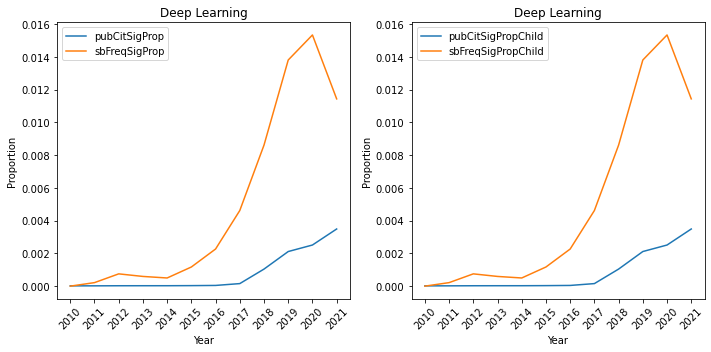

In [26]:
# now plot dui2pubCitSigPropChild[sample_dui] and dui2pubFreqSigPropChild[sample_dui] next to each other. specify sbirs with red and publications with blue lines. make the font size of x axis and y axis and the title bigger.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(years[START_YEAR_IDX:], dui2pubCitSigProp[sample_dui], label='pubCitSigProp')
ax[0].plot(years[START_YEAR_IDX:], dui2sbCitSigProp[sample_dui], label='sbFreqSigProp')
ax[0].set_title(sample_name)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Proportion')
ax[0].legend()
ax[1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropchild[sample_dui], label='pubCitSigPropChild')
ax[1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropchild[sample_dui], label='sbFreqSigPropChild')
ax[1].set_title(sample_name)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Proportion')
ax[1].legend()
for a in ax.flat:
    for tick in a.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

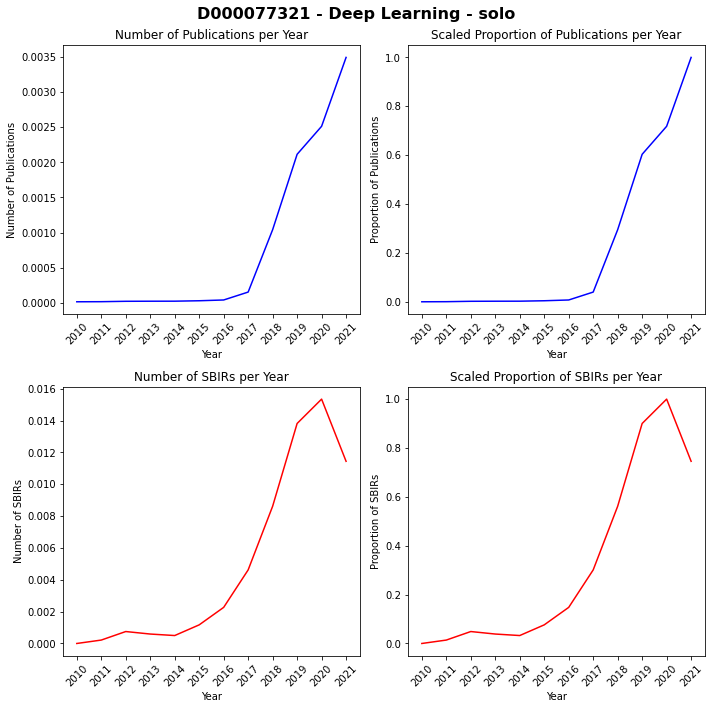

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' - solo', fontsize=16, fontweight='bold')
axs[0, 0].plot(years[START_YEAR_IDX:], dui2pubCitSigProp[sample_dui], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaled[sample_dui], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years[START_YEAR_IDX:], dui2sbCitSigProp[sample_dui], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaled[sample_dui], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()


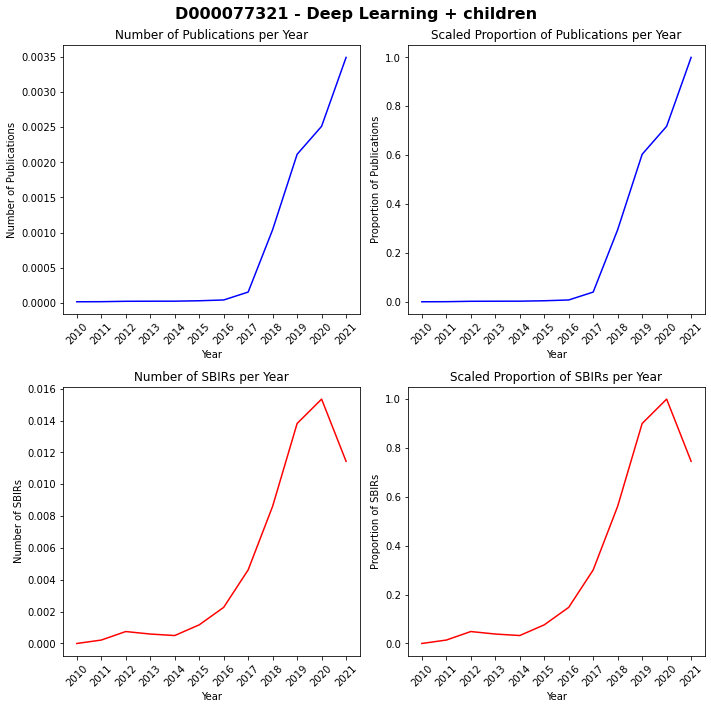

In [30]:
#draw the same for dui2pubFreqSigchild and dui2pubCitSigPropchild 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' + children', fontsize=16, fontweight='bold')
axs[0, 0].plot(years[START_YEAR_IDX:], dui2pubCitSigPropchild[sample_dui], color='blue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Publications')
axs[0, 0].set_title('Number of Publications per Year')
axs[0, 1].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaledchild[sample_dui], color='blue')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Proportion of Publications')
axs[0, 1].set_title('Scaled Proportion of Publications per Year')
axs[1, 0].plot(years[START_YEAR_IDX:], dui2sbCitSigPropchild[sample_dui], color='red')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of SBIRs')
axs[1, 0].set_title('Number of SBIRs per Year')
axs[1, 1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaledchild[sample_dui], color='red')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Proportion of SBIRs')
axs[1, 1].set_title('Scaled Proportion of SBIRs per Year')

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [31]:
# ('D000081186', 'Blockchain')
# ('D000077321', 'Deep Learning')
# ('D012137', 'Respiratory System')
# ('D000069550', 'Machine Learning')
# ('D019876', 'Sports Equipment')

sample_dui = 'D000069550'
year = '2020'
sample_name = dui2name[sample_dui]
print(sample_dui, sample_name, year)

D000069550 Machine Learning 2020


In [32]:
print(len(dui2pubfreq[sample_dui][year]), dui2pubfreq[sample_dui][year])
print(len(dui2sbfreq[sample_dui][year]), dui2sbfreq[sample_dui][year])
print(len(dui2pubfreqchild[sample_dui][year]), dui2pubfreqchild[sample_dui][year])
print(len(dui2sbfreqchild[sample_dui][year]), dui2sbfreqchild[sample_dui][year])

5136 [32538625, 33161227, 32079904, 32473122, 32833571, 32079910, 33194024, 31424555, 33521709, 32079917, 32768046, 32768053, 31916093, 32014404, 32047172, 32178250, 33095769, 32243801, 32047210, 32505964, 32702573, 32702574, 32899184, 31916153, 31948926, 32145537, 33554565, 32768133, 32931989, 33489060, 32276658, 32014516, 32309431, 32112826, 33226940, 32932028, 33194173, 32309439, 32997569, 32211144, 32964809, 33226957, 33030350, 32473309, 32407774, 32080093, 32800992, 32375024, 32899326, 32112901, 32112907, 32899346, 32932128, 32801058, 32375076, 32047411, 33358138, 33456445, 32375102, 32997716, 32735577, 33096026, 33227106, 32407907, 35520871, 33358189, 32735604, 32473467, 33292688, 32932240, 32113043, 32637333, 32833958, 33259944, 32080299, 32604588, 33227180, 32735660, 33128875, 32604598, 32702902, 32866745, 32768443, 32604604, 33259973, 32833991, 32080330, 32866762, 32604623, 32604633, 32604635, 32866798, 33489395, 33128961, 32539144, 32604683, 32801298, 32342553, 32244257, 3260

In [33]:
print(np.sum(dui2pubcit[sample_dui][year]), dui2pubcit[sample_dui][year])
print(np.sum(dui2sbcit[sample_dui][year]), dui2sbcit[sample_dui][year])
print(np.sum(dui2pubcitchild[sample_dui][year]), dui2pubcitchild[sample_dui][year])
print(np.sum(dui2sbcitchild[sample_dui][year]), dui2sbcitchild[sample_dui][year])

3601.5 [1, 1, 1, 0.75, 1, 0.5, 0.25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.25, 1, 0.5, 0.25, 0.75, 0.25, 0.75, 1, 1, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 1, 0.25, 1, 0.25, 1, 0.25, 0.75, 0.5, 1, 0.75, 1, 0.25, 0.5, 0.5, 0.75, 1, 0.75, 0.75, 1, 1, 1, 0.75, 0.5, 0.5, 0.25, 1, 0.25, 1, 1, 1, 1, 1, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 1, 0.25, 0.75, 1, 1, 1, 0.25, 1, 1, 0.5, 0.5, 0.75, 1, 0.75, 1, 0.5, 1, 1, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 0.25, 0.25, 0.5, 1, 0.25, 0.75, 1, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 1, 0.25, 0.5, 1, 0.5, 1, 0.75, 1, 1, 0.75, 1, 0.5, 0.5, 1, 0.25, 1, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.75, 1, 0.75, 0.75, 1, 0.25, 1, 1, 0.75, 0.5, 1, 0.75, 0.5, 0.5, 1, 1, 0.5, 0.25, 0.25, 0.75, 1, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 1, 0.75, 0.25, 0.75, 0.75, 1, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 1, 0.75, 1, 1, 1, 0.75, 1, 0.5, 0.25, 0.75, 0.5, 1, 1, 0.25, 0.25, 0.75, 0.5, 1, 1, 0.25, 0.25, 1, 1, 0.5, 0.75, 0.25, 0.5, 1, 1, 1, 1, 0.75, 0.75, 1, 

In [34]:
print(dui2pubCitSigProp[sample_dui])
print(dui2sbCitSigProp[sample_dui])
print(dui2pubCitSigPropchild[sample_dui])
print(dui2sbCitSigPropchild[sample_dui])

[0.00011939019983135465, 0.00010255067825129504, 0.00012618240268237927, 0.00017260426743104105, 0.00029777993420749, 0.0010938768734696882, 0.0014416566222855832, 0.0019670300432079566, 0.0028926362601441992, 0.0038067890777501385, 0.0043526853494339785, 0.005928402742504556]
[0.002247016891368356, 0.0036452004860267314, 0.003374261880213703, 0.005260428243313329, 0.006314390162844799, 0.0074981082754350965, 0.008890745271197565, 0.01349380014587892, 0.023648247177658944, 0.04148595134829342, 0.04991394148020654, 0.047908493120406695]
[0.00020933438625138866, 0.0005271464689057798, 0.0007896432337473275, 0.0009044966344262563, 0.001098815983638959, 0.0019203529221076667, 0.0022995492150492763, 0.0030863896810555784, 0.004899469701845059, 0.0067262052890529325, 0.007522175097841755, 0.010116047144770851]
[0.002634433596776693, 0.004002573082696019, 0.0045927453369575405, 0.0057049714751426246, 0.006646726487205052, 0.008186008117218133, 0.011217853093860015, 0.01823486506199854, 0.0311

In [35]:
print(dui2pubCitSigPropScaled[sample_dui])
print(dui2sbCitSigPropScaled[sample_dui])
print(dui2pubCitSigPropScaledchild[sample_dui])
print(dui2sbCitSigPropScaledchild[sample_dui]) 

[0.002890482180861564, 0.0, 0.004056355048231605, 0.012024608316024114, 0.03351085022465616, 0.1701598640482228, 0.2298558098052101, 0.32003548054316144, 0.47891459500191214, 0.6358277482237512, 0.7295301398504447, 1.0]
[0.0, 0.02933236424876838, 0.023648368309234405, 0.06321807790072116, 0.08532904748020749, 0.11016216022663965, 0.13937816289043584, 0.2359452251539665, 0.4489744297726722, 0.8231899749226398, 1.0, 0.9579278844377251]
[0.0, 0.0320804781970773, 0.058577336563724575, 0.07017082912564007, 0.08978574619746031, 0.1727130459480473, 0.21098974803729606, 0.29041472836991383, 0.47343002970993586, 0.6578237465497563, 0.7381702578689943, 1.0]
[0.0, 0.023528788046563283, 0.0336783656476739, 0.052806044758272684, 0.06900202060624414, 0.09547405184961537, 0.14761466951296, 0.2682908059871504, 0.4911625997872793, 0.8367911530271522, 1.0, 0.9335071277208684]


## Frequency Analysis

In [36]:
print(dui2pubfreq['D000069550']['2020'])
print(dui2sbfreq['D000069550']['2020'])

[32538625, 33161227, 32079904, 32473122, 32833571, 32079910, 33194024, 31424555, 33521709, 32079917, 32768046, 32768053, 31916093, 32014404, 32047172, 32178250, 33095769, 32243801, 32047210, 32505964, 32702573, 32702574, 32899184, 31916153, 31948926, 32145537, 33554565, 32768133, 32931989, 33489060, 32276658, 32014516, 32309431, 32112826, 33226940, 32932028, 33194173, 32309439, 32997569, 32211144, 32964809, 33226957, 33030350, 32473309, 32407774, 32080093, 32800992, 32375024, 32899326, 32112901, 32112907, 32899346, 32932128, 32801058, 32375076, 32047411, 33358138, 33456445, 32375102, 32997716, 32735577, 33096026, 33227106, 32407907, 35520871, 33358189, 32735604, 32473467, 33292688, 32932240, 32113043, 32637333, 32833958, 33259944, 32080299, 32604588, 33227180, 32735660, 33128875, 32604598, 32702902, 32866745, 32768443, 32604604, 33259973, 32833991, 32080330, 32866762, 32604623, 32604633, 32604635, 32866798, 33489395, 33128961, 32539144, 32604683, 32801298, 32342553, 32244257, 32604706,

In [37]:
tmp = []
for dui in dui2pubfreq:
    for year in years:
        if 33246195 in dui2pubfreq[dui][year]:
            tmp.append((dui, year))
tmp = [(dui2name[each[0]], each[0], each[1]) for each in tmp]
print(tmp)

[('Humans', 'D006801', '2020'), ('Acrosome', 'D000177', '2020'), ('Semen Analysis', 'D055101', '2020'), ('Algorithms', 'D000465', '2020'), ('Spermatozoa', 'D013094', '2020')]


In [39]:
dui2sbfreq['D055101']

{'2010': [],
 '2011': [],
 '2012': [],
 '2013': [],
 '2014': [],
 '2015': [],
 '2016': [],
 '2017': ['S031663'],
 '2018': [],
 '2019': ['S020669'],
 '2020': ['S011110'],
 '2021': ['S003784']}

## 4. Granger Causality Analysis

**Measurement of Trend Causality**  

We now apply the **Granger Causality** test to our MeSH term time series. Specifically:
- We form pairs of signals `(PubMed, SBIR)` for each MeSH term.
- We test if past values of one signal can predict future values of the other, up to a maximum lag of 11 years.

A p-value < 0.05 suggests that scientific activity in a given MeSH term (publication frequency/impact) is a statistically significant predictor of subsequent SBIR activity for the same MeSH term, or vice versa.

In [41]:
#calculate the granger causality between two time series for up to 11 lags
def granger_causality(x, y, maxlag):
    result = grangercausalitytests(np.array([x, y]).T, maxlag=maxlag, verbose=False)
    return result

#create dui2gc dictionary to store the granger causality p-values for each dui
dui2gcChild = {}
c = 0
for dui in tqdm(dui2pubCitSigPropScaledchild):
    sig_a = dui2pubCitSigPropScaledchild[dui]
    sig_b = dui2sbCitSigPropScaledchild[dui]
    #replace nans with 0s
    sig_a = np.nan_to_num(sig_a)
    sig_b = np.nan_to_num(sig_b)

    #upsample to to make the stretch the length of each signal from 12 to 36
    sig_a = np.repeat(sig_a, 3)
    sig_b = np.repeat(sig_b, 3)

    try:
        granger = granger_causality(sig_b, sig_a, 11)
        dui2gcChild[dui] = granger
    except Exception as e:
        if str(type(e)) == "<class 'statsmodels.tools.sm_exceptions.InfeasibleTestError'>":
            c += 1
            dui2gcChild[dui] = None

print(c)
#save dui2gc dictionary to a pickle file
with open(PICKLES_ADDRESS + 'dui2gcchild_imp.pickle', 'wb') as handle:
    pickle.dump(dui2gcChild, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('saved dui2gcChild')

  0%|          | 0/10873 [00:00<?, ?it/s]/home/admin/VS Code Projects/JPMC/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████| 10873/10873 [01:59<00:00, 90.79it/s] 


2416
saved dui2gcChild


In [42]:
#load dui2gc dictionary from pickle file
with open(PICKLES_ADDRESS + 'dui2gcchild_imp.pickle', 'rb') as handle:
    dui2gcChild = pickle.load(handle)
print('loaded dui2gcChild')

loaded dui2gcChild


In [43]:
max_depth = 13
mlag = 11
depth_wise_chi2tests_maxlen = []
depth_wise_chi2tests_std = []
depth_wise_lrtests_maxlen = []
depth_wise_lrtests_std = []
multi_level_duis = []
for depth in range(1, max_depth + 1):
    try:
        print('depth:', depth + 1)
        dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level] if dui in dui2gcChild]
        multi_level_duis.append(dui_subset)

        print('len(dui_subset):', len(dui_subset))

        lag2chi2tests = {}
        lag2lrtests = {}
        for lag in list(range(1, 12)):
            dui_subset_chi2tests = [dui2gcChild[dui][lag][0]['ssr_chi2test'][1] if dui2gcChild[dui] else 1 for dui in dui_subset]
            dui_subset_lrtests = [dui2gcChild[dui][lag][0]['lrtest'][1] if dui2gcChild[dui] else 1 for dui in dui_subset]

            chi2tests_significant_ratio = len([chi2test for chi2test in dui_subset_chi2tests if chi2test < 0.05]) / len(dui_subset_chi2tests)
            lrtests_significant_ratio = len([lrtest for lrtest in dui_subset_lrtests if lrtest < 0.05]) / len(dui_subset_lrtests)

            lag2chi2tests[lag] = chi2tests_significant_ratio
            lag2lrtests[lag] = lrtests_significant_ratio

        depth_wise_chi2tests_maxlen.append(lag2chi2tests[mlag])
        depth_wise_chi2tests_std.append(np.std(list(lag2chi2tests.values())))
        depth_wise_lrtests_maxlen.append(lag2lrtests[mlag])
        depth_wise_lrtests_std.append(np.std(list(lag2lrtests.values())))

        print('chi2tests_significant_ratio:', round(depth_wise_chi2tests_maxlen[-1], 4), '±', round(depth_wise_chi2tests_std[-1], 4))
        print('lrtests_significant_ratio:', round(depth_wise_lrtests_maxlen[-1], 4), '±', round(depth_wise_lrtests_std[-1], 4))
        print('=' * 50)
        #save the results to a pickle file
        with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_maxlen_imp.pickle', 'wb') as handle:
            pickle.dump(depth_wise_chi2tests_maxlen, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_std_imp.pickle', 'wb') as handle:
            pickle.dump(depth_wise_chi2tests_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_lrtests_maxlen_imp.pickle', 'wb') as handle:
            pickle.dump(depth_wise_lrtests_maxlen, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_lrtests_std_imp.pickle', 'wb') as handle:
            pickle.dump(depth_wise_lrtests_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('saved')

    except:
        print('=' * 50)
        print('depth:', depth)
        print('=' * 50)

depth: 2
len(dui_subset): 58
chi2tests_significant_ratio: 0.7759 ± 0.2684
lrtests_significant_ratio: 0.7069 ± 0.2447
saved
depth: 3
len(dui_subset): 853
chi2tests_significant_ratio: 0.8066 ± 0.2522
lrtests_significant_ratio: 0.7057 ± 0.2225
saved
depth: 4
len(dui_subset): 2976
chi2tests_significant_ratio: 0.7819 ± 0.2457
lrtests_significant_ratio: 0.6912 ± 0.2173
saved
depth: 5
len(dui_subset): 5653
chi2tests_significant_ratio: 0.7638 ± 0.2399
lrtests_significant_ratio: 0.6777 ± 0.2131
saved
depth: 6
len(dui_subset): 7880
chi2tests_significant_ratio: 0.7473 ± 0.2366
lrtests_significant_ratio: 0.6642 ± 0.2107
saved
depth: 7
len(dui_subset): 9283
chi2tests_significant_ratio: 0.7409 ± 0.2345
lrtests_significant_ratio: 0.6578 ± 0.2087
saved
depth: 8
len(dui_subset): 10019
chi2tests_significant_ratio: 0.7368 ± 0.2332
lrtests_significant_ratio: 0.6547 ± 0.2075
saved
depth: 9
len(dui_subset): 10491
chi2tests_significant_ratio: 0.7332 ± 0.2322
lrtests_significant_ratio: 0.6521 ± 0.2066
saved
d

In [46]:
with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_maxlen_freq.pickle', 'rb') as handle:
    depth_wise_chi2tests_maxlen_freq = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_std_freq.pickle', 'rb') as handle:
    depth_wise_chi2tests_std_freq = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_lrtests_maxlen_freq.pickle', 'rb') as handle:
    depth_wise_lrtests_maxlen_freq = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_lrtests_std_freq.pickle', 'rb') as handle:
    depth_wise_lrtests_std_freq = pickle.load(handle)

with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_maxlen_imp.pickle', 'rb') as handle:
    depth_wise_chi2tests_maxlen_imp = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_std_imp.pickle', 'rb') as handle:
    depth_wise_chi2tests_std_imp = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_lrtests_maxlen_imp.pickle', 'rb') as handle:
    depth_wise_lrtests_maxlen_imp = pickle.load(handle)
with open(PICKLES_ADDRESS + 'depth_wise_lrtests_std_imp.pickle', 'rb') as handle:
    depth_wise_lrtests_std_imp = pickle.load(handle)

#make them all numpy arrays
depth_wise_chi2tests_maxlen_freq = np.array(depth_wise_chi2tests_maxlen_freq) * 100
depth_wise_chi2tests_std_freq = np.array(depth_wise_chi2tests_std_freq) * 100
depth_wise_lrtests_maxlen_freq = np.array(depth_wise_lrtests_maxlen_freq) * 100
depth_wise_lrtests_std_freq = np.array(depth_wise_lrtests_std_freq) * 100

depth_wise_chi2tests_maxlen_imp = np.array(depth_wise_chi2tests_maxlen_imp) * 100
depth_wise_chi2tests_std_imp = np.array(depth_wise_chi2tests_std_imp) * 100
depth_wise_lrtests_maxlen_imp = np.array(depth_wise_lrtests_maxlen_imp) * 100
depth_wise_lrtests_std_imp = np.array(depth_wise_lrtests_std_imp) * 100

print('len(depth_wise_chi2tests_maxlen):', len(depth_wise_chi2tests_maxlen_freq))
print('len(depth_wise_chi2tests_std):', len(depth_wise_chi2tests_std_freq))
print('len(depth_wise_lrtests_maxlen):', len(depth_wise_lrtests_maxlen_freq))
print('len(depth_wise_lrtests_std):', len(depth_wise_lrtests_std_freq))

print('len(depth_wise_chi2tests_maxlen_imp):', len(depth_wise_chi2tests_maxlen_imp))
print('len(depth_wise_chi2tests_std_imp):', len(depth_wise_chi2tests_std_imp))
print('len(depth_wise_lrtests_maxlen_imp):', len(depth_wise_lrtests_maxlen_imp))
print('len(depth_wise_lrtests_std_imp):', len(depth_wise_lrtests_std_imp))

len(depth_wise_chi2tests_maxlen): 13
len(depth_wise_chi2tests_std): 13
len(depth_wise_lrtests_maxlen): 13
len(depth_wise_lrtests_std): 13
len(depth_wise_chi2tests_maxlen_imp): 13
len(depth_wise_chi2tests_std_imp): 13
len(depth_wise_lrtests_maxlen_imp): 13
len(depth_wise_lrtests_std_imp): 13


In [47]:
lrtest_freq_error_max = np.minimum(depth_wise_lrtests_maxlen_freq + depth_wise_chi2tests_std_freq, 99.9) - depth_wise_lrtests_maxlen_freq
chi2tests_freq_error_max = np.minimum(depth_wise_chi2tests_maxlen_freq + depth_wise_chi2tests_std_freq, 99.9) - depth_wise_chi2tests_maxlen_freq
lrtest_imp_error_max = np.minimum(depth_wise_lrtests_maxlen_imp + depth_wise_chi2tests_std_imp, 99.9) - depth_wise_lrtests_maxlen_imp
chi2tests_imp_error_max = np.minimum(depth_wise_chi2tests_maxlen_imp + depth_wise_chi2tests_std_imp, 99.9) - depth_wise_chi2tests_maxlen_imp

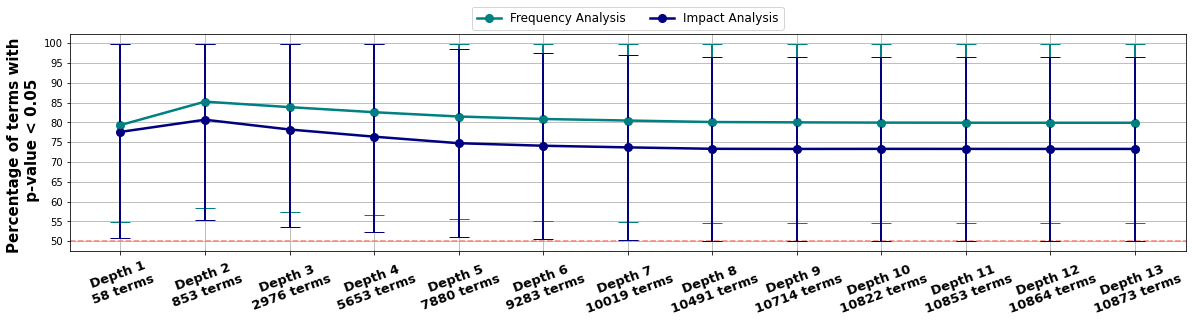

In [48]:
import matplotlib.pyplot as plt

x = ['Depth ' + str(each + 1) + '\n' + str(len(multi_level_duis[each])) + ' terms' for each in range(len(depth_wise_chi2tests_maxlen_freq))]

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')
line2, = ax.plot(x, depth_wise_chi2tests_maxlen_freq, marker='o', color='teal', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax.errorbar(x, depth_wise_chi2tests_maxlen_freq, yerr=[depth_wise_chi2tests_std_freq, chi2tests_freq_error_max], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
line4, = ax.plot(x, depth_wise_chi2tests_maxlen_imp, marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax.errorbar(x, depth_wise_chi2tests_maxlen_imp, yerr=[depth_wise_chi2tests_std_imp, chi2tests_imp_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with \n p-value < 0.05', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=20, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 5))  # Set y-axis ticks from 50 to 100 in steps of 10

# # Add annotations for the first line
# for i, val in enumerate(max_window_imp_percents):
#     val_formatted = '{:.2f}'.format(val)
#     ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(30, 15), ha='center', fontsize=14, color='black')

# # Add annotations for the second line
# for i, val in enumerate(max_window_freq_percents):
#     val_formatted = '{:.2f}'.format(val)
#     ax.annotate(f'{val_formatted}', (i, val), textcoords="offset points", xytext=(30, 15), ha='center', fontsize=14, color='black')

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.15), ncol=4)  # Add legend
plt.savefig('impact_vs_freq_granger_causality.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Cross-Correlation and CCAUC Ratio

**Cross-Correlation Area Under the Curve**  

1. We compute the **cross-correlation** between the scaled scientific signal (pub/frequency) and the SBIR signal (sb/frequency) for each MeSH term.  
2. We identify the **maximum correlation lag** and measure the area under the curve on both sides of zero-lag.  
3. As described in Equations (6)–(7) of the paper, the **CCAUC ratio** indicates whether the industrial signal more likely lags the scientific signal (`>1`), or leads it (`<1`).

This analysis helps us observe how the frequency or impact of scientific publications might precede or follow SBIR funding trends over time.

In [49]:
# create a dui2cc dictionary that maps a dui to a scipy cross correlation between the scaled pub and sbir frequencies
a, b, c, d, cnan = 0, 0, 0, 0, 0
dui2cc = {}
dui2ccchild = {}
for dui in tqdm(dui2pubCitSigPropScaled):
    sigA, sigB = dui2pubCitSigPropScaled[dui], dui2sbCitSigPropScaled[dui]
    if len(sigA) == 0:
        a += 1
        continue
    if len(sigB) == 0:
        b += 1
        continue
    # if there is a nan, add one to cnan
    if np.isnan(sigA).any() or np.isnan(sigB).any():
        cnan += 1
    sigA = np.nan_to_num(sigA)
    sigB = np.nan_to_num(sigB)
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2cc[dui] = corr
    
for dui in tqdm(dui2pubCitSigPropScaledchild):
    sigA, sigB = dui2pubCitSigPropScaledchild[dui], dui2sbCitSigPropScaledchild[dui]
    if len(sigA) == 0:
        c += 1
        continue
    if len(sigB) == 0:
        d += 1
        continue
    sigA = np.nan_to_num(sigA)
    sigB = np.nan_to_num(sigB)
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2ccchild[dui] = corr

#save the dui2cc and dui2ccchild dictionaries in data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2cc, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2ccchild, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(a, b)
print(c, d)
print(cnan)
print('Saved dui2cc and dui2ccchild.')
print('len(dui2cc):', len(dui2cc))
print('len(dui2ccchild):', len(dui2ccchild))

100%|██████████| 10873/10873 [00:00<00:00, 20868.28it/s]

0 0
0 0
0
Saved dui2cc and dui2ccchild.
len(dui2cc): 10873
len(dui2ccchild): 10873


In [50]:
len(lags), len(dui2cc[sample_dui])
lags

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11])

In [51]:
#load the dui2cc and dui2ccchild dictionaries from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc_cVersion.pickle', 'rb') as handle:
    dui2cc = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild_cVersion.pickle', 'rb') as handle:
    dui2ccchild = pickle.load(handle)

print('Loaded dui2cc and dui2ccchild.')

Loaded dui2cc and dui2ccchild.


In [52]:
# ('D000081186', 'Blockchain')
# ('D000077321', 'Deep Learning')
# ('D012137', 'Respiratory System')
# ('D000069550', 'Machine Learning')
# ('D009490', ''Neurosecretory Systems')
# ('D019876', 'Sports Equipment')
# ('D014612', 'Vaccines')
# ('D009369', 'Neoplasms')
# ('D009446', 'Neurobiology')

sample_dui = 'D055585'
sample_name = dui2name[sample_dui]
print(sample_dui, sample_name)
print(dui2pubCitSigPropScaled[sample_dui])
print(dui2sbCitSigPropScaled[sample_dui])
print(dui2pubCitSigPropScaledchild[sample_dui])
print(dui2sbCitSigPropScaledchild[sample_dui]) 

D055585 Physical Phenomena
[0.36626503091763585, 0.0632973551229511, 0.010134181748201519, 0.15958733409719802, 0.1758430927134991, 0.0, 0.22016620221194685, 0.3826907094769477, 0.3612420975707429, 0.30433970611851857, 0.4879272978726701, 1.0]
[0.8331179592467542, 1.0, 0.4019594729456746, 0.17822689855680535, 0.08108440265329463, 0.5675751279989806, 0.0, 0.24065683010951347, 0.5906945330448071, 0.4259814858507874, 0.24039417078114517, 0.1760789768121831]
[1.0, 0.8181887082880874, 0.8170916246395539, 0.7298431473301374, 0.650544733715649, 0.5854710517059568, 0.45211940968674863, 0.4085623630741506, 0.38324565696263496, 0.1987820474075983, 0.0, 0.26852947936923655]
[0.30872086370183655, 1.0, 0.9856651667476102, 0.0, 0.5700711867781971, 0.5291304976775544, 0.4261145409729, 0.18487053708870096, 0.280067171387604, 0.16415649621676773, 0.40287398451562156, 0.40310255077568513]


In [53]:
c = 0
for dui in dui2sbCitSigPropScaled:
    if sum(dui2sbCitSigPropScaled[dui]) == 0:
        c += 1
len(dui2sbCitSigPropScaled), c

(10873, 833)

maximum_correlation_lag: 1
pos_auc: 4.849293122951601
neg_auc: 3.649850780129621
ccauc: 1.2579528676377318


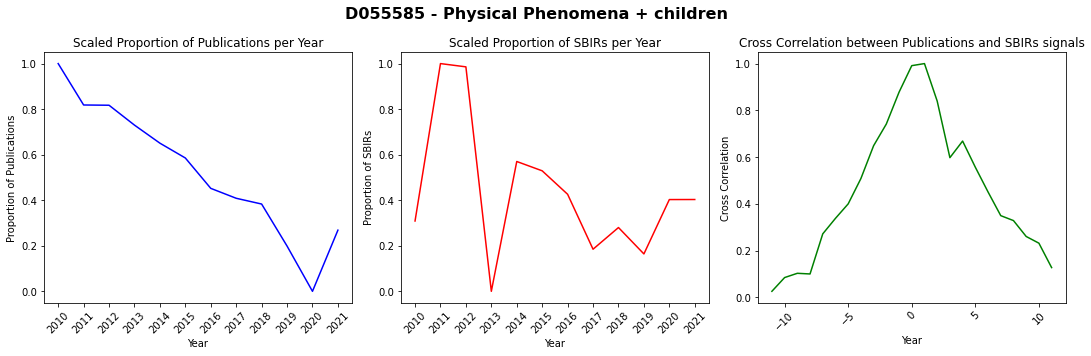

In [54]:
# plot three plots next to each other, one for dui2pubCitSigPropScaled, one for dui2sbCitSigPropScaled, and one for dui2cc
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' + children', fontsize=16, fontweight='bold')
axs[0].plot(years[START_YEAR_IDX:], dui2pubCitSigPropScaledchild[sample_dui], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Proportion of Publications')
axs[0].set_title('Scaled Proportion of Publications per Year')
axs[1].plot(years[START_YEAR_IDX:], dui2sbCitSigPropScaledchild[sample_dui], color='red')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Proportion of SBIRs')
axs[1].set_title('Scaled Proportion of SBIRs per Year')
axs[2].plot(correlation_lags, dui2ccchild[sample_dui], color='green')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Cross Correlation')
axs[2].set_title('Cross Correlation between Publications and SBIRs signals')

# calculate the maximum correlation lag
maximum_correlation_lag = correlation_lags[np.argmax(dui2ccchild[sample_dui])]
print('maximum_correlation_lag:', maximum_correlation_lag)
#calcualte the AUC of the cross-correlation signal
zero_index = correlation_lags.index(0)
pos_auc = np.trapz(dui2ccchild[sample_dui][zero_index + 1:], dx=1)
neg_auc = np.trapz(dui2ccchild[sample_dui][:zero_index], dx=1)
ccauc = (pos_auc + 1) / (neg_auc + 1)

print('pos_auc:', pos_auc)
print('neg_auc:', neg_auc)
print('ccauc:', ccauc)

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [55]:
# create dui2mcclag and dui2mcclagchild
dui2mcclag = {}
dui2mcclagchild = {}
dui2aucratio = {}
dui2aucratiochild = {}
for dui in tqdm(dui2cc):
    dui2mcclag[dui] = correlation_lags[np.argmax(dui2cc[dui])]
for dui in tqdm(dui2ccchild):
    dui2mcclagchild[dui] = correlation_lags[np.argmax(dui2ccchild[dui])]
for dui in tqdm(dui2cc):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2cc[dui][zero_index + 1:], dx=1)
    neg_auc = np.trapz(dui2cc[dui][:zero_index], dx=1)
    dui2aucratio[dui] = (pos_auc + 1) / (neg_auc + 1)
for dui in tqdm(dui2ccchild):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2ccchild[dui][zero_index:], dx=1)
    neg_auc = np.trapz(dui2ccchild[dui][:zero_index], dx=1)
    dui2aucratiochild[dui] = (pos_auc + 1) / (neg_auc + 1)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2mcclag, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2mcclagchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2aucratio, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild_cVersion.pickle', 'wb') as handle:
    pickle.dump(dui2aucratiochild, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('len(dui2mcclag):', len(dui2mcclag))
print('len(dui2mcclagchild):', len(dui2mcclagchild))
print('len(dui2aucratio):', len(dui2aucratio))
print('len(dui2aucratiochild):', len(dui2aucratiochild))

100%|██████████| 10873/10873 [00:00<00:00, 92878.17it/s]

len(dui2mcclag): 10873
len(dui2mcclagchild): 10873
len(dui2aucratio): 10873
len(dui2aucratiochild): 10873


In [56]:
# load dui2mcclag and dui2mcclagchild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag_cVersion.pickle', 'rb') as handle:
    dui2mcclag = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild_cVersion.pickle', 'rb') as handle:
    dui2mcclagchild = pickle.load(handle)
# load dui2aucratio and dui2aucratiochild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio_cVersion.pickle', 'rb') as handle:
    dui2aucratio = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild_cVersion.pickle', 'rb') as handle:
    dui2aucratiochild = pickle.load(handle)

print('len(dui2mcclag):', len(dui2mcclag))
print('len(dui2mcclagchild):', len(dui2mcclagchild))
print('len(dui2aucratio):', len(dui2aucratio))
print('len(dui2aucratiochild):', len(dui2aucratiochild))

len(dui2mcclag): 10873
len(dui2mcclagchild): 10873
len(dui2aucratio): 10873
len(dui2aucratiochild): 10873


In [57]:
#select duis from levels 0 to 3 from level1duis
depth = 10
dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
len(dui_subset)

29169

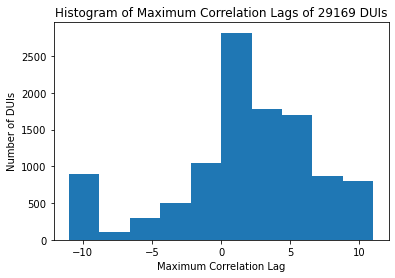

In [58]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclag[dui] for dui in dui_subset if dui in dui2mcclag]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 2857
zero: 1531
pos: 6434


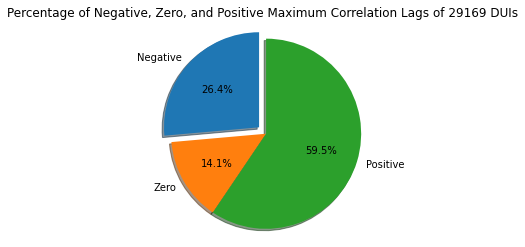

In [59]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2mcclag[dui] for dui in dui_subset if dui in dui2mcclag]
neg = len([lag for lag in dui_subset_mcclags if lag < 0])
zero = len([lag for lag in dui_subset_mcclags if lag == 0])
pos = len([lag for lag in dui_subset_mcclags if lag > 0])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.show()

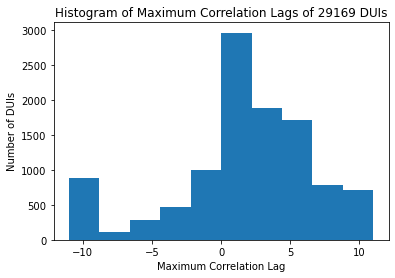

In [60]:
# create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
plt.hist(dui_subset_mcclags, bins=10)
plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.xlabel('Maximum Correlation Lag')
plt.ylabel('Number of DUIs')
plt.show()

neg: 2747
zero: 1661
pos: 6414


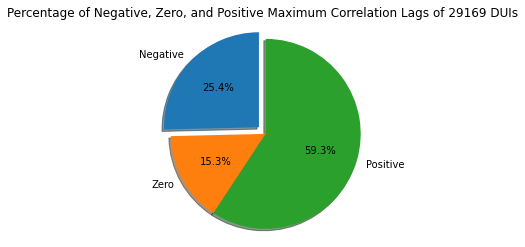

In [61]:
#return the percentage of negative, zero, and positive maximum correlation lags as a circle graph
dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
neg = len([lag for lag in dui_subset_mcclags if lag < 0])
zero = len([lag for lag in dui_subset_mcclags if lag == 0])
pos = len([lag for lag in dui_subset_mcclags if lag > 0])
print('neg:', neg)
print('zero:', zero)
print('pos:', pos)

labels = 'Negative', 'Zero', 'Positive'
sizes = [neg, zero, pos]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
fig1.patch.set_facecolor('white')
plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
plt.show()

depth: 1
[]
len(dui_subset): 0
neg: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
depth: 2
[('D012140', 0.6052384261481696), ('D007254', 2.5454867808651507), ('D002319', 2.089763716563167), ('D055641', 1.158437602536541), ('D018514', 1.2282862503694787), ('D002477', 2.622028881363212), ('D055598', 1.8992564519588713), ('D013812', 2.4690535555414725), ('D009422', 1.0541131751358495), ('D055585', 1.4720634308897114), ('D002318', 0.9303296770961477), ('D013514', 2.2551049032947343), ('D001523', 1.5334406933772482), ('D012137', 0.7083347304856787), ('D014947', 1.4536411258148332), ('D006281', 0.9918694380012921), ('D004364', 1.6506660386475516), ('D008827', 1.0851469749413998), ('D001686', 3.1306477814198432), ('D007154', 2.2193543053345457), ('D056890', 0.8183181450593902), ('D009140', 2.136315474573374), ('D003933', 2.931614522619524), ('D009057', 3.5830824750585526), ('D008660', 2.605404108327808), ('D001685', 2.666594357044024), ('D005128', 0.9032600662928675), ('D009420', 3.252985676702722), ('D0080

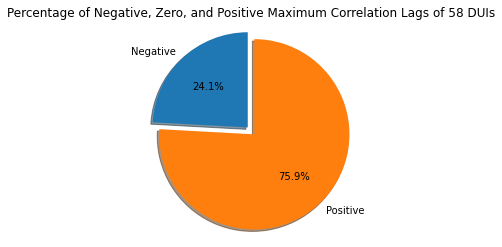

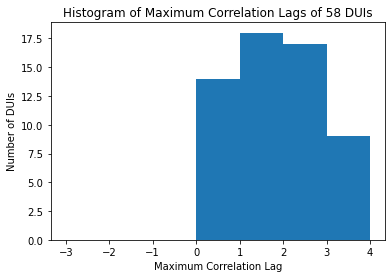

depth: 3
[('D014937', 1.5482283702586324), ('D017741', 1.0), ('D003273', 3.450370918207171), ('D004798', 3.8652695950162337), ('D010919', 4.849789009726566), ('D020878', 5.327905923081244), ('D012586', 0.5692492825960451), ('D008107', 1.4751825322397536), ('D017831', 6.812917037583121), ('D008566', 2.6804402718219738), ('D008962', 1.6992040237580324), ('D006094', 2.044845499430604), ('D000013', 3.855790212442902), ('D004427', 1.883496591725896), ('D009132', 2.928458694170567), ('D006296', 1.0), ('D055442', 0.9492575590553584), ('D000068079', 0.5668063766173999), ('D010106', 4.378872487911309), ('D002384', 1.7549212087113577), ('D036341', 3.9459823287383102), ('D014930', 1.0), ('D002448', 2.883120347279433), ('D003646', 1.9303569375193332), ('D010600', 3.6301302149518357), ('D002454', 3.0531107915062536), ('D000091282', 3.0274322693697577), ('D003711', 0.9787986948452542), ('D014116', 4.724712574561156), ('D064307', 1.2056271980582898), ('D064420', 1.827107894316756), ('D057210', 1.7724

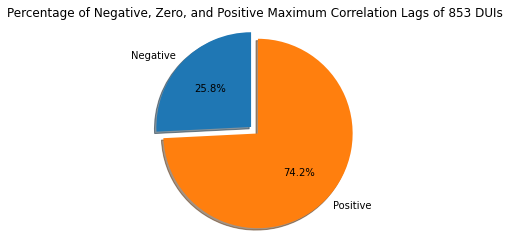

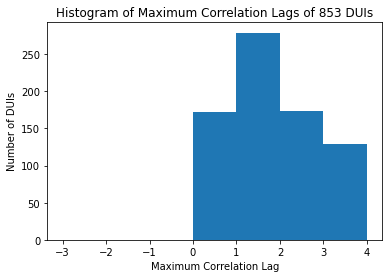

depth: 4
[('D017563', 1.377503575511202), ('D002627', 3.499354030076232), ('D058728', 0.42092373644878256), ('D003069', 0.6005393003988162), ('D019693', 2.984715069175143), ('D020714', 4.851464540627811), ('D018630', 3.3931205459716516), ('D006019', 1.1720364777835106), ('D054792', 2.2455788963361707), ('D058447', 0.5748091527933228), ('D009681', 2.296221685053618), ('D008262', 2.0129786877545044), ('D063646', 1.932258842644029), ('D005356', 3.978141155813139), ('D008051', 3.9135491443278334), ('D012433', 3.6639733491974873), ('D012151', 1.0317138047668242), ('D010195', 1.762387745497424), ('D021721', 1.5317398498122474), ('D010209', 1.2142677623438114), ('D003617', 6.781070157823339), ('D010778', 0.6295046458783063), ('D057925', 5.004207538166374), ('D055370', 1.3118157700851714), ('D004547', 4.472711918850224), ('D015858', 4.852386880064495), ('D058013', 0.6226553137038351), ('D004741', 2.04555325141768), ('D007448', 2.182968424904782), ('D018846', 3.530357284154548), ('D040441', 1.0

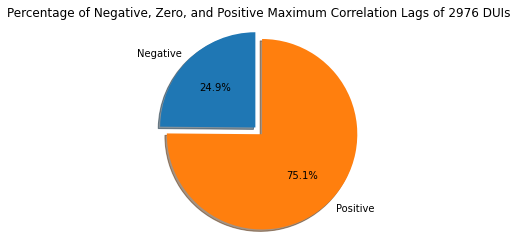

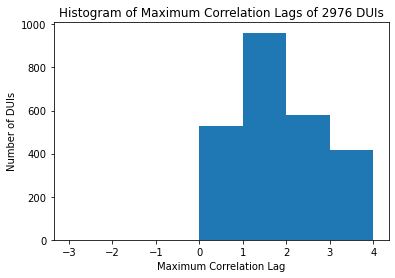

depth: 5
[('D000075065', 5.62215512487062), ('D059247', 4.4051417869099545), ('D010173', 4.843486171209382), ('D024002', 3.8966941125410046), ('D003187', 4.526401404782577), ('D014691', 1.0), ('D000649', 5.0466671003812476), ('D011588', 2.6636456759673406), ('D014699', 2.7686509080988584), ('D002065', 3.8700336508404893), ('D016172', 2.661161945081703), ('D003540', 5.8823192108084985), ('D066128', 1.18515683675868), ('D007802', 1.7719787535676907), ('D000067563', 4.846232597164921), ('D053590', 4.161733291990801), ('D019829', 2.885295780743892), ('D000076122', 2.8916444793870024), ('D002586', 1.146930329585197), ('D020773', 1.4244203032655436), ('D009773', 1.0), ('D018670', 1.9489466238021318), ('D062105', 1.2575509957049842), ('D009989', 2.1773869644672383), ('D000072916', 0.9074983720020674), ('D001228', 2.6406448663875994), ('D007265', 3.6947535735019934), ('D011392', 4.111139291431174), ('D006503', 4.152465953342831), ('D004502', 1.8469590162956344), ('D006764', 1.0), ('D005263', 6

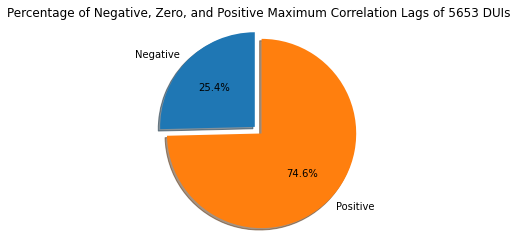

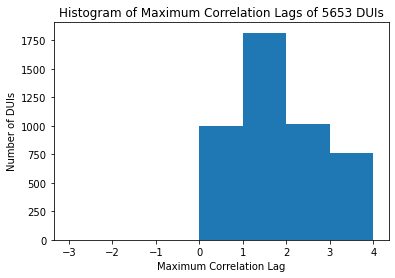

depth: 6
[('D014995', 6.389817714268478), ('D000081246', 1.5826280630839582), ('D005371', 1.1328420619641495), ('D051339', 7.507472135154926), ('D002328', 1.2128378582528645), ('D049631', 4.020423657656552), ('D000583', 0.8819415742080662), ('D002824', 3.1433635365337973), ('D006776', 1.0), ('D000803', 4.9271243489229395), ('D000060', 1.0), ('D032921', 0.853257271304385), ('D042461', 4.511685784392347), ('D002302', 0.7789562191075161), ('D004461', 1.4173195693630454), ('D056464', 3.207552959389893), ('D000114', 3.7758575451649663), ('D017156', 1.2387298200411696), ('D054582', 1.0), ('D000076282', 0.8171255946062246), ('D006358', 1.0), ('D044043', 5.2711082677065635), ('D010174', 5.698207376574504), ('D008046', 4.088167511639897), ('D006850', 6.907572238735093), ('D052247', 7.145066357761129), ('D054581', 1.0), ('D005079', 2.3465177011105633), ('D011825', 0.36644745166947595), ('D001012', 3.4990498206095), ('D002295', 4.762446446540569), ('D017439', 0.4893481116773934), ('D005072', 3.00

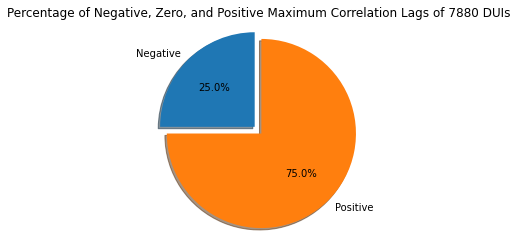

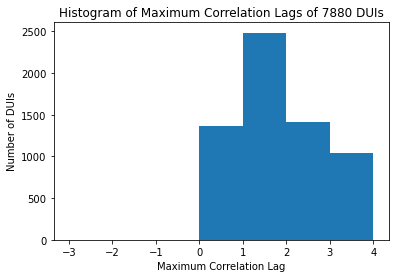

depth: 7
[('D007922', 0.4049871109446164), ('D012381', 2.2962244676201133), ('D000249', 0.3699736416634184), ('D046969', 1.230711702077787), ('D053139', 4.90066285637838), ('D062788', 3.7539660930549985), ('D015293', 2.4016180032537693), ('D012865', 1.0022533228520805), ('D000077195', 1.0728531321749106), ('D005782', 0.7349747946474794), ('D058976', 0.8447179176304904), ('D008246', 5.796136941673638), ('D003919', 2.5338122664907727), ('D007888', 5.785330746532349), ('D006506', 1.9080535887074574), ('D000077310', 0.8137437313073185), ('D008543', 1.5128262335917888), ('D003056', 4.599713814962784), ('D011055', 0.7203658988037275), ('D044784', 0.5384944750942766), ('D014103', 1.8792875208385817), ('D032763', 1.3805148999155958), ('D002130', 2.9548186152456073), ('D030016', 1.1949128554921753), ('D016718', 3.6378766182391673), ('D018538', 1.1803113529436928), ('D003841', 3.6820642248653086), ('D000077144', 2.4451329725814834), ('D016264', 1.3821975902208143), ('D008098', 3.0801182833778227

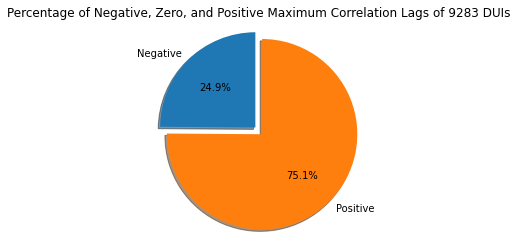

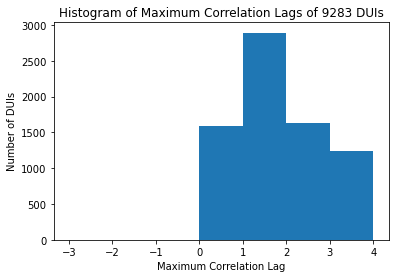

depth: 8
[('D005881', 1.9499057274921578), ('D001491', 1.8536973091825153), ('D001735', 3.0172477904837343), ('D016410', 2.202597108843663), ('D004900', 2.5058883378637686), ('D011241', 4.03759239417242), ('D004335', 1.3200004673098886), ('D014141', 1.3964274087876718), ('D020169', 3.8066905042061587), ('D015251', 6.964633160180333), ('D017085', 4.034176219342723), ('D003400', 0.94677239814864), ('D052248', 5.690809188064686), ('D044950', 0.6223439727511866), ('D014104', 0.6598513836288566), ('D019057', 1.0), ('D012083', 3.6498736281544018), ('D019362', 2.8471915561542476), ('D000074062', 1.0), ('D017470', 4.276338645842304), ('D011237', 1.0), ('D000071066', 2.520363809697), ('D017948', 1.9779909776493667), ('D019005', 1.574690007024817), ('D005733', 2.4709793986100306), ('D019741', 2.2754011831453287), ('D058430', 0.6313283127607473), ('D013609', 1.0419665479100964), ('D066246', 3.3169813348912256), ('D000083262', 0.34543759487848624), ('D004458', 0.2529067951271069), ('D054703', 2.29

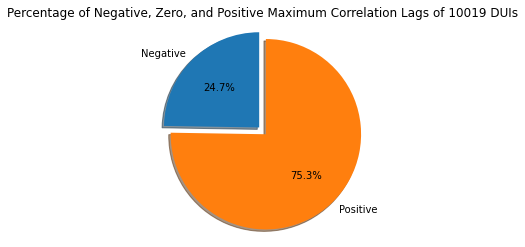

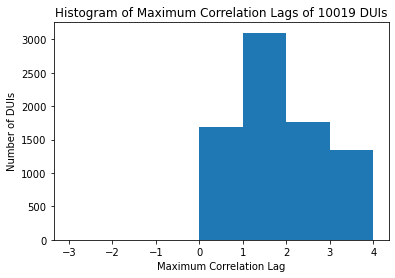

depth: 9
[('D057127', 5.735060318879416), ('D047388', 4.861821891169476), ('D031944', 4.889087453858127), ('D014812', 1.2382326569129605), ('D064486', 0.4871989156519864), ('D000882', 0.7738794585265245), ('D020781', 2.8682035870006417), ('D016335', 3.9745819669088043), ('D005625', 4.079829479903577), ('D000992', 1.5047427947521312), ('D029902', 2.863117514010392), ('D000070003', 5.197877405065551), ('D031042', 2.2119111044363353), ('D027702', 3.2975121185680405), ('D000080907', 1.0), ('D017448', 5.1780968431892225), ('D007347', 3.7701371011040443), ('D008273', 2.242813813108591), ('D031484', 2.3010439083561653), ('D056564', 1.7403034452554622), ('D031701', 4.156429425105834), ('D048668', 3.402195641654762), ('D054768', 6.5688333201740585), ('D040301', 2.484455234580228), ('D030017', 5.506590621635278), ('D018724', 1.395695660268243), ('D001726', 3.4528133385262616), ('D007382', 0.5946153105161627), ('D051301', 2.958602169270908), ('D031022', 4.273646291371299), ('D051197', 2.650062705

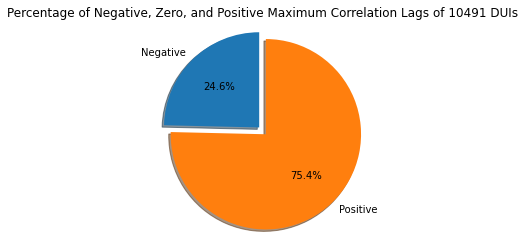

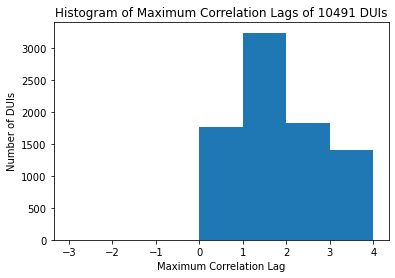

depth: 10
[('D054893', 3.5868800255314435), ('D018342', 4.48720313188933), ('D062486', 1.0), ('D027723', 0.49596197900460093), ('D000069557', 2.5669567253157557), ('D010129', 3.514619504958724), ('D020379', 1.0), ('D015802', 4.207481621704028), ('D050681', 1.1801114113978757), ('D055611', 3.5106332228573116), ('D043705', 4.650785751716699), ('D022161', 0.9275000136531983), ('D018091', 1.4803961729592967), ('D055114', 0.8265234358829241), ('D002736', 1.799142811108763), ('D016762', 2.1469260202560356), ('D044105', 5.090380378529649), ('D053616', 1.531729361974416), ('D064652', 1.2420826838482606), ('D016219', 1.0), ('D054397', 6.083102474078434), ('D044103', 3.3952100950697366), ('D016176', 2.86013973953009), ('D048728', 3.6710054657621276), ('D000069455', 2.3044078761119433), ('D000076222', 8.67166278978424), ('D000068258', 5.030621899122047), ('D007142', 4.947830198197442), ('D007137', 5.314019416898521), ('D004166', 0.659969031493802), ('D002212', 0.6069792116840949), ('D018113', 1.5

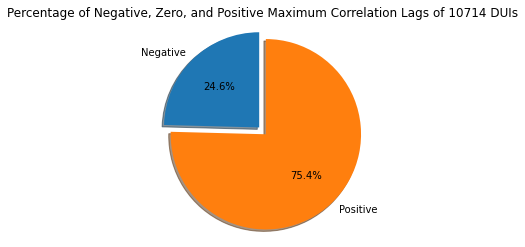

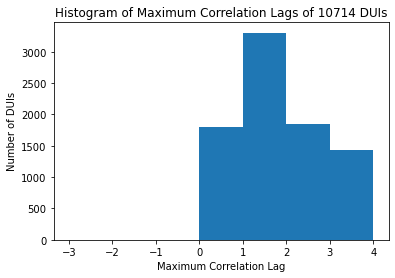

depth: 11
[('D032413', 1.720872689275976), ('D031965', 5.942418629050329), ('D031955', 2.1242912015348594), ('D000091246', 0.22743173750317078), ('D031989', 0.9484600657682332), ('D020457', 0.28566607663768506), ('D051658', 2.442895057186218), ('D014863', 0.8387517134343884), ('D018911', 5.170239625685284), ('D048888', 2.7089264406358544), ('D000080882', 0.584399466554345), ('D006853', 3.3013098881192144), ('D054894', 1.4874920775591156), ('D065856', 1.0277722704514882), ('D033621', 0.7586972453932854), ('D032108', 0.45045846191650823), ('D001000', 3.228952503464371), ('D016645', 5.6503003303950505), ('D031325', 0.7278885600982318), ('D012278', 3.5682122641507408), ('D029799', 4.750270652238982), ('D046008', 1.9593646987092501), ('D012519', 4.225970329495142), ('D027845', 0.7393371578793607), ('D051379', 3.447275481251163), ('D019596', 1.8772532645107336), ('D015440', 1.7017397857724068), ('D013602', 4.941201923708779), ('D006377', 2.9229336381590096), ('D031985', 0.9271617069456741), 

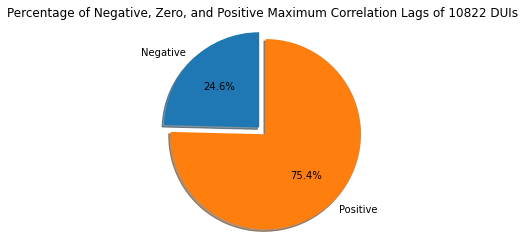

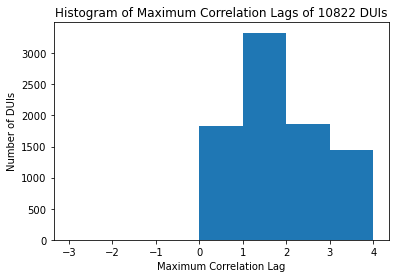

depth: 12
[('D027826', 0.33481708015489986), ('D028521', 0.44067605703552787), ('D000086542', 1.7306418278542084), ('D054520', 3.4663302521446364), ('D030024', 0.5713434327302899), ('D015186', 0.775849007771364), ('D004285', 3.923860726157102), ('D030681', 1.6595006120965383), ('D000504', 6.372916389223597), ('D000075942', 1.805728781265469), ('D032107', 2.651072711002007), ('D030221', 2.686450817074385), ('D055354', 1.0711077049179583), ('D009714', 7.107875487066255), ('D019950', 6.206903255028881), ('D002612', 1.028525789624325), ('D054501', 4.3410981782567495), ('D017836', 1.8924627017385645), ('D017173', 3.5427595739979703), ('D000079702', 0.5922705314226872), ('D048054', 5.767921864669643), ('D009036', 4.41781496083627), ('D031622', 2.51895566289842), ('D048052', 4.6844874905734555), ('D050378', 3.3495475867625455), ('D016699', 5.526703117489916), ('D011992', 5.530842597577165), ('D018734', 3.5392682588523012), ('D018649', 1.373468954268958), ('D054465', 5.215367086975726), ('D019

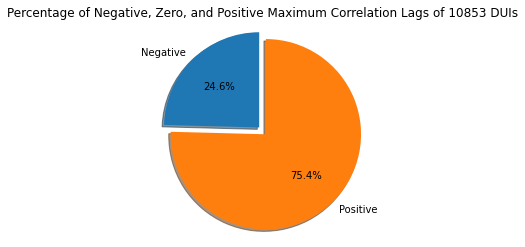

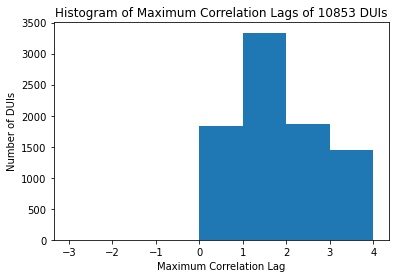

depth: 13
[('D030221', 2.686450817074385), ('D055354', 1.0711077049179583), ('D009714', 7.107875487066255), ('D019950', 6.206903255028881), ('D002612', 1.028525789624325), ('D054501', 4.3410981782567495), ('D017836', 1.8924627017385645), ('D017173', 3.5427595739979703), ('D000079702', 0.5922705314226872), ('D048054', 5.767921864669643), ('D009036', 4.41781496083627), ('D031622', 2.51895566289842), ('D048052', 4.6844874905734555), ('D050378', 3.3495475867625455), ('D016699', 5.526703117489916), ('D011992', 5.530842597577165), ('D018734', 3.5392682588523012), ('D018649', 1.373468954268958), ('D054465', 5.215367086975726), ('D019413', 1.765761545065012), ('D032384', 0.5751909555149916), ('D005289', 2.776832395536996), ('D010041', 0.8187908317295078), ('D018900', 3.7768516651091013), ('D011181', 3.4390632174625964), ('D019597', 1.6863855565907806), ('D002520', 3.62234254954545), ('D013712', 1.4066984218596923), ('D027582', 0.8275150049260919), ('D031446', 1.806731141442648), ('D002188', 0.

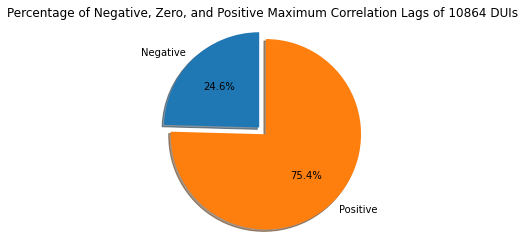

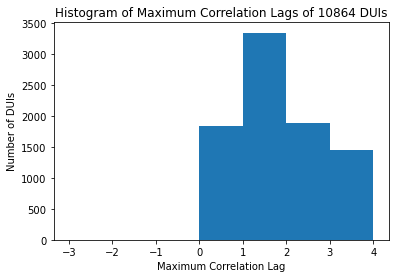

depth: 14
[('D048054', 5.767921864669643), ('D009036', 4.41781496083627), ('D031622', 2.51895566289842), ('D048052', 4.6844874905734555), ('D050378', 3.3495475867625455), ('D016699', 5.526703117489916), ('D011992', 5.530842597577165), ('D018734', 3.5392682588523012), ('D018649', 1.373468954268958), ('D054465', 5.215367086975726), ('D019413', 1.765761545065012), ('D032384', 0.5751909555149916), ('D005289', 2.776832395536996), ('D010041', 0.8187908317295078), ('D018900', 3.7768516651091013), ('D011181', 3.4390632174625964), ('D019597', 1.6863855565907806), ('D002520', 3.62234254954545), ('D013712', 1.4066984218596923), ('D027582', 0.8275150049260919), ('D031446', 1.806731141442648), ('D002188', 0.7544525537591988), ('D029661', 0.5166614078458547), ('D018728', 1.918046905979519), ('D000177', 3.1318063463917394), ('D046011', 1.3843199897572964), ('D029662', 2.567313044196583), ('D050636', 2.776253649364985), ('D018773', 3.5326592352829485), ('D051659', 1.7989677910836637), ('D000071476', 0

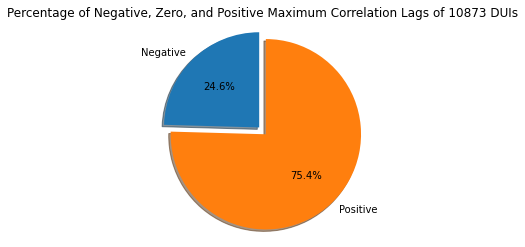

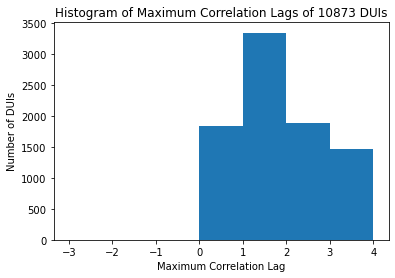

In [62]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
single_level_duis_mcclags = []
single_level_duis = []
multi_level_duis_mcclags = []
greater_one_percentages = []
greater_one_std = []
greater_one_maxs = []
greater_one_mins = []
for depth in range(max_depth + 1):
    print('depth:', depth + 1)
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level] if dui in dui2aucratiochild]
    dui_subset_mcclags = [dui2aucratiochild[dui] for dui in dui_subset]
    print(list(zip(dui_subset[-100:], dui_subset_mcclags[-100:])))
    print('len(dui_subset):', len(dui_subset_mcclags))
    neg = len([lag for lag in dui_subset_mcclags if lag <= 1])
    pos = len([lag for lag in dui_subset_mcclags if lag > 1])
    ppos = pos / (len(dui_subset_mcclags) + 0.000000001) * 100
    # pzero = zero / (len(dui_subset_mcclags) + 0.000000001) * 100
    pneg = neg / (len(dui_subset_mcclags) + 0.000000001) * 100
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', pneg)
    # print('zero:', zero, 'Ratio:', pzero)
    print('pos:', pos, 'Ratio:', ppos)

    if neg + pos == 0:
        print('=' * 50)
        continue

    dui_subset_single_level = [dui for dui in level2duis[depth] if dui in dui2aucratiochild]
    single_level_duis.append(dui_subset_single_level)
    print('len(dui_subset_single_level):', len(dui_subset_single_level))
    dui_subset_single_level_mcclags = [dui2aucratiochild[dui] for dui in dui_subset_single_level]
    single_level_duis_mcclags.append(dui_subset_single_level_mcclags)
    greater_one_maxs.append([dui_subset_single_level[np.argmax(dui_subset_single_level_mcclags)], np.max(dui_subset_single_level_mcclags)])
    greater_one_mins.append([dui_subset_single_level[np.argmin(dui_subset_single_level_mcclags)], np.min(dui_subset_single_level_mcclags)])
    dui_greater_one_std = np.std(dui_subset_single_level_mcclags)
    greater_one_std.append(dui_greater_one_std)
    greater_one_percentages.append(ppos)
    multi_level_duis_mcclags.append(dui_subset_mcclags)
    
    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Positive'
    sizes = [neg, pos]
    explode = (0.1, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -3 to 5 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-3, 5, 1))
    plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.xlabel('Maximum Correlation Lag')
    plt.ylabel('Number of DUIs')
    plt.show()

   #save pos / (len(dui_subset_mcclags) + 0.000000001) * 100 to a txt file named like STIDX_<START_FROM_IDX>_DEPTH_<depth>.txt at data/SF11/results
    with open(LAG_DATA_ADDRESS + SF_TAG + '/results/DEPTH_' + str(depth) + '_IMP.txt', 'w') as f:
        f.write(str(ppos))
    
    print('=' * 50)

In [63]:
zero2duis = {
    'Anatomy [A]': 'U000002',
    'Organisms [B]': 'U000012',
    'Diseases [C]': 'U000006',
    'Chemicals and Drugs [D]': 'U000005',
    'Analytical, Diagnostic and Therapeutic Techniques and Equipment [E]': 'U000001',
    'Psychiatry and Psychology [F]': 'U000014',
    'Phenomena and Processes [G]': 'U000004',
    'Disciplines and Occupations [H]': 'U000013',
    'Anthropology, Education, Sociology and Social Phenomena [I]': 'U000003',
    'Technology, Industry, Agriculture [J]': 'U000009',
    'Information Sience [K]': 'U000010',
    'Named Groups [M]': 'U000011',
    'Health Care [N]': 'U000008',
    'Publication Characteristics [V]': 'U000016',
    'Geographicals [Z] ': 'U000015',
}
dui2zero = {v: k for k, v in zero2duis.items()}
dui2zero

{'U000002': 'Anatomy [A]',
 'U000012': 'Organisms [B]',
 'U000006': 'Diseases [C]',
 'U000005': 'Chemicals and Drugs [D]',
 'U000001': 'Analytical, Diagnostic and Therapeutic Techniques and Equipment [E]',
 'U000014': 'Psychiatry and Psychology [F]',
 'U000004': 'Phenomena and Processes [G]',
 'U000013': 'Disciplines and Occupations [H]',
 'U000003': 'Anthropology, Education, Sociology and Social Phenomena [I]',
 'U000009': 'Technology, Industry, Agriculture [J]',
 'U000010': 'Information Sience [K]',
 'U000011': 'Named Groups [M]',
 'U000008': 'Health Care [N]',
 'U000016': 'Publication Characteristics [V]',
 'U000015': 'Geographicals [Z] '}

In [64]:
# dui = 'D000077321'
zero2chilren = {zdui: [] for zdui in level2duis[0]}

for zero_level_dui in level2duis[0]:
    for first_level_dui in level2duis[1]:
        parent = dui2parents[first_level_dui][-2]
        if zero_level_dui == parent:
            zero2chilren[zero_level_dui] += [first_level_dui]

zero2chilren['U000010']

['D007254']

DUI: U000010
Name: Information Sience [K]
len(dui_subset): 362
neg: 60 Ratio: 31.746031745863778
zero: 46 Ratio: 24.338624338495567
pos: 83 Ratio: 43.91534391511156


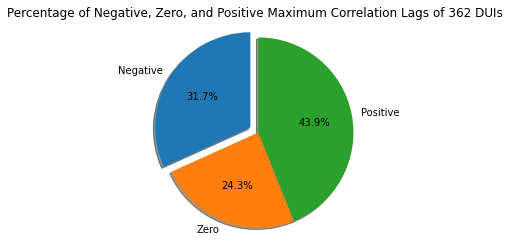

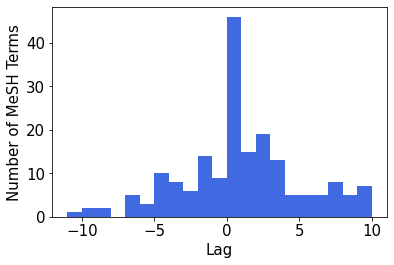

DUI: U000004
Name: Phenomena and Processes [G]
len(dui_subset): 1349
neg: 153 Ratio: 20.105124835716026
zero: 145 Ratio: 19.053876478292963
pos: 463 Ratio: 60.8409986858596


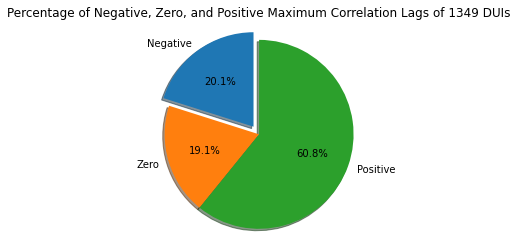

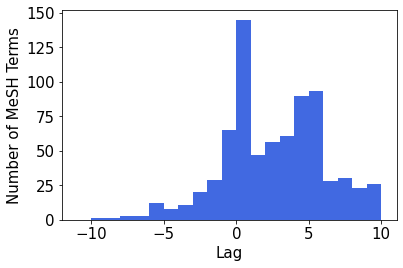

DUI: U000011
Name: Named Groups [M]
len(dui_subset): 0
neg: 0 Ratio: 0.0
zero: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
DUI: U000012
Name: Organisms [B]
len(dui_subset): 3848
neg: 181 Ratio: 22.624999999971717
zero: 142 Ratio: 17.749999999977813
pos: 477 Ratio: 59.624999999925464


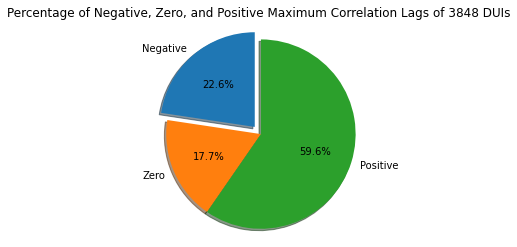

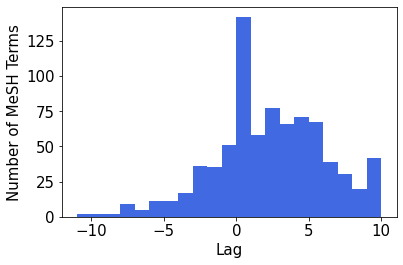

DUI: U000003
Name: Anthropology, Education, Sociology and Social Phenomena [I]
len(dui_subset): 142
neg: 34 Ratio: 43.03797468299952
zero: 15 Ratio: 18.987341771911552
pos: 30 Ratio: 37.974683543823105


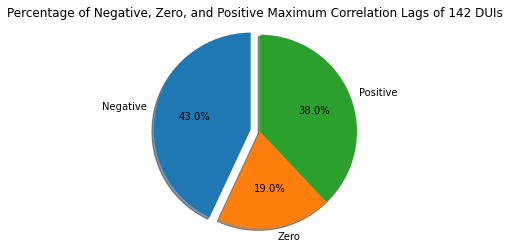

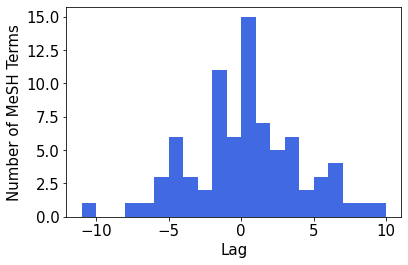

DUI: U000013
Name: Disciplines and Occupations [H]
len(dui_subset): 855
neg: 96 Ratio: 25.39682539675821
zero: 84 Ratio: 22.222222222163435
pos: 198 Ratio: 52.3809523808138


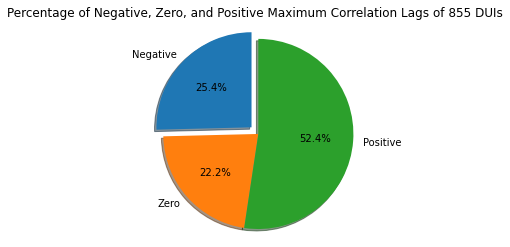

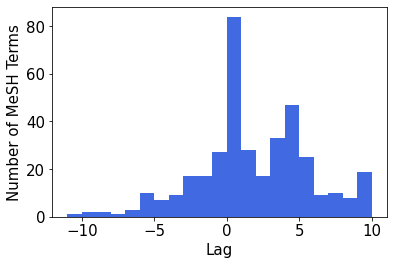

DUI: U000006
Name: Diseases [C]
len(dui_subset): 3662
neg: 245 Ratio: 21.138912855892027
zero: 237 Ratio: 20.448662640189433
pos: 677 Ratio: 58.41242450383226


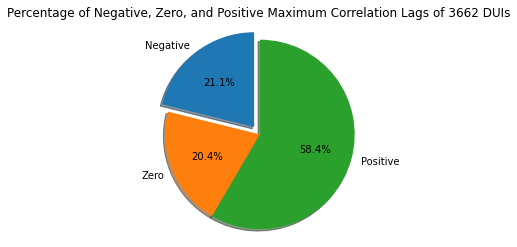

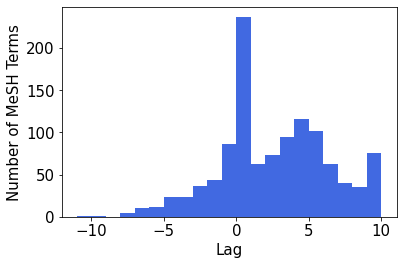

DUI: U000015
Name: Geographicals [Z] 
len(dui_subset): 20
neg: 6 Ratio: 74.999999990625
zero: 0 Ratio: 0.0
pos: 2 Ratio: 24.999999996875


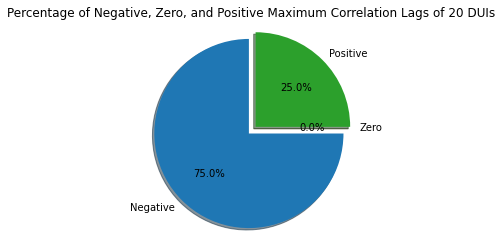

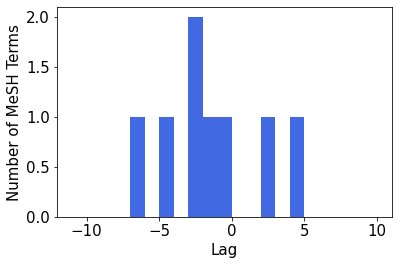

DUI: U000001
Name: Analytical, Diagnostic and Therapeutic Techniques and Equipment [E]
len(dui_subset): 1640
neg: 120 Ratio: 15.564202334610163
zero: 131 Ratio: 16.990920881949428
pos: 520 Ratio: 67.4448767833107


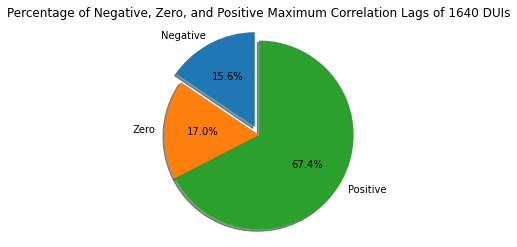

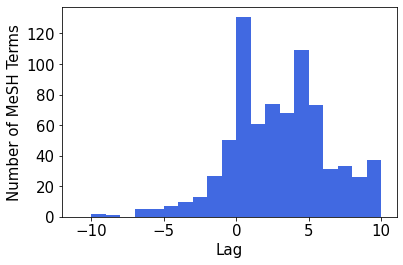

DUI: U000002
Name: Anatomy [A]
len(dui_subset): 1131
neg: 66 Ratio: 13.924050632882018
zero: 79 Ratio: 16.666666666631507
pos: 329 Ratio: 69.40928270027551


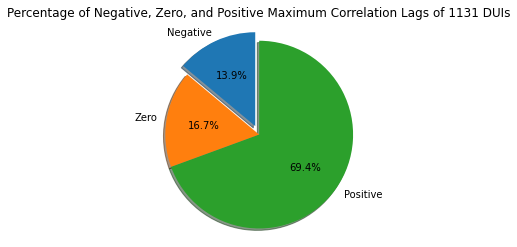

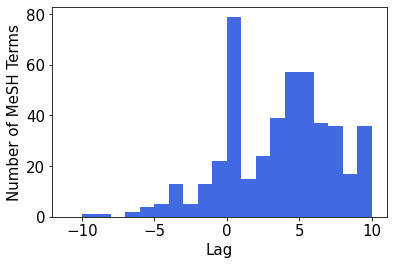

DUI: U000009
Name: Technology, Industry, Agriculture [J]
len(dui_subset): 164
neg: 13 Ratio: 27.0833333327691
zero: 13 Ratio: 27.0833333327691
pos: 22 Ratio: 45.83333333237847


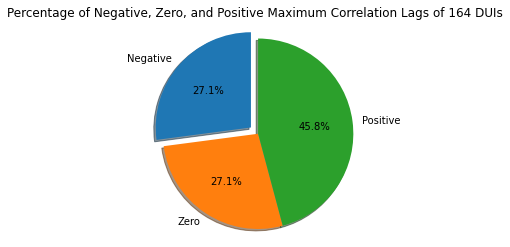

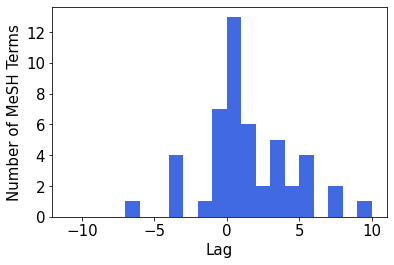

DUI: U000014
Name: Psychiatry and Psychology [F]
len(dui_subset): 338
neg: 36 Ratio: 25.899280575353245
zero: 23 Ratio: 16.546762589809017
pos: 80 Ratio: 57.553956834118324


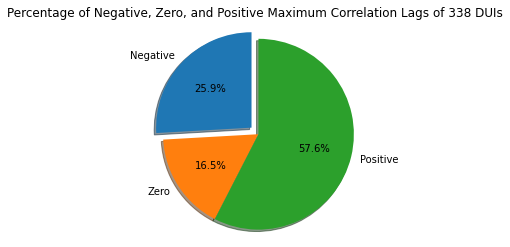

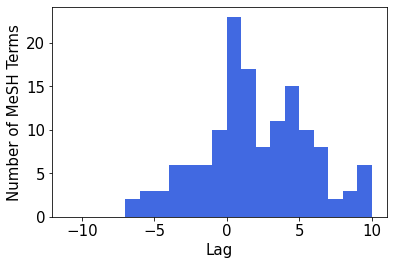

DUI: U000005
Name: Chemicals and Drugs [D]
len(dui_subset): 6470
neg: 321 Ratio: 16.385911179164683
zero: 206 Ratio: 10.51556916793746
pos: 1432 Ratio: 73.09851965284682


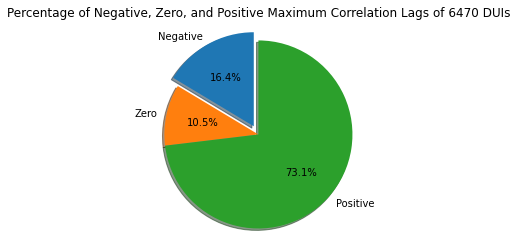

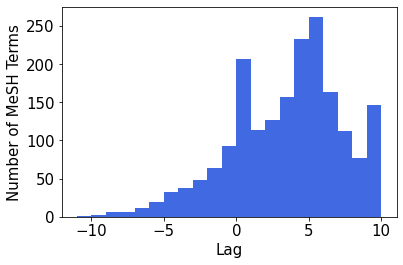

DUI: U000008
Name: Health Care [N]
len(dui_subset): 0
neg: 0 Ratio: 0.0
zero: 0 Ratio: 0.0
pos: 0 Ratio: 0.0


In [65]:
zero_level_lags = {}

# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
for zero_level_dui in level2duis[0]:
    print('DUI:', zero_level_dui)
    print('Name:', dui2zero[zero_level_dui])
    dui_subset = []
    for first_level_child in zero2chilren[zero_level_dui]:
        dui_subset += dui2children[first_level_child]
    print('len(dui_subset):', len(dui_subset))
    dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
    neg = len([lag for lag in dui_subset_mcclags if lag < 0])
    zero = len([lag for lag in dui_subset_mcclags if lag == 0])
    pos = len([lag for lag in dui_subset_mcclags if lag > 0])
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', neg / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('zero:', zero, 'Ratio:', zero / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('pos:', pos, 'Ratio:', pos / (len(dui_subset_mcclags) + 0.000000001) * 100)

    if neg + zero + pos == 0:
        print('=' * 50)
        continue

    zero_level_lags[dui2zero[zero_level_dui]] = dui_subset_mcclags
    
    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Zero', 'Positive'
    sizes = [neg, zero, pos]
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -11 to 11 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-11, 11, 1), color='royalblue')
    # plt.title('Histogram of MCC Lags', fontsize=15)
    plt.xlabel('Lag', fontsize=15)
    plt.ylabel('Number of MeSH Terms', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('plots/citation/' + zero_level_dui + '_' + dui2zero[zero_level_dui] + '_hist.png', dpi=300)
    plt.show()

    print('=' * 50)

In [66]:
def return_total_count_of_dui(dui, the_dict):
    count = 0
    for year in years:
        if year in the_dict[dui]:
            count += len(the_dict[dui][year])
    return count

def return_annual_count_of_dui(dui, the_dict):
    year2count = {}
    for year in years:
        if year in the_dict[dui]:
            year2count[year] = len(the_dict[dui][year])
    return year2count

# return_total_count_of_dui('D007254', dui2pubfreq)
return_annual_count_of_dui('D007254', dui2pubfreq)

{'2010': 7,
 '2011': 14,
 '2012': 9,
 '2013': 17,
 '2014': 11,
 '2015': 9,
 '2016': 19,
 '2017': 11,
 '2018': 7,
 '2019': 8,
 '2020': 10,
 '2021': 9}

In [67]:
name2dui = {v: k for k, v in dui2name.items()}
name2dui['Blockchain']

'D000081186'

In [68]:
zero_level_percentages = {}

# Function to calculate the percentile threshold
def calculate_percentile_threshold(data, percentile):
    return np.percentile(data, percentile)

# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
zero_level_info = {}
for zero_level_dui in level2duis[0]:
    try:
    # if True:
        print('DUI:', zero_level_dui)
        print('Name:', dui2zero[zero_level_dui])
        dui_subset = []
        for first_level_child in zero2chilren[zero_level_dui]:
            dui_subset += dui2children[first_level_child]
        print('len(dui_subset):', len(dui_subset))
        
        dui_subset_auc_dict = {dui2name[dui]: dui2aucratiochild[dui] for dui in dui_subset if dui in dui2aucratiochild}
        dui_subset_mcclags_dict = {dui: dui2mcclagchild[name2dui[dui]] for dui in dui_subset_auc_dict if name2dui[dui] in dui2mcclagchild}
        # Calculate the dynamic threshold based on percentile
        all_counts = [return_total_count_of_dui(name2dui[dui], dui2pubfreqchild) for dui in dui_subset_mcclags_dict]
        percentile_threshold = calculate_percentile_threshold(all_counts, 90)  

        to_be_removed = []
        for dui in dui_subset_mcclags_dict:
            # add dui to the to_be_removed list if its total count is below the percentile threshold
            if return_total_count_of_dui(name2dui[dui], dui2pubfreqchild) < percentile_threshold:
                to_be_removed.append(dui)
        
        for dui in to_be_removed:
            del dui_subset_mcclags_dict[dui]
            del dui_subset_auc_dict[dui]

        # print every child's auc ratio
        top_5_pos_children_auc = sorted(dui_subset_auc_dict.items(), key=lambda x: x[1], reverse=True)[:5]
        top_5_pos_children_auc_corresponding_mcclags = {each[0]: dui_subset_mcclags_dict[each[0]] for each in top_5_pos_children_auc}
        top_5_pos_children2annual_count = {each[0]: return_annual_count_of_dui(name2dui[each[0]], dui2pubfreqchild) for each in top_5_pos_children_auc}
        top_5_neg_children_auc = sorted(dui_subset_auc_dict.items(), key=lambda x: x[1], reverse=False)[:5]
        top_5_neg_children_auc_corresponding_mcclags = {each[0]: dui_subset_mcclags_dict[each[0]] for each in top_5_neg_children_auc}
        top_5_neg_children2annual_count = {each[0]: return_annual_count_of_dui(name2dui[each[0]], dui2pubfreqchild) for each in top_5_pos_children_auc}
                
        top_5_pos_children_auc = {each[0]: each[1] for each in top_5_pos_children_auc}
        top_5_neg_children_auc = {each[0]: each[1] for each in top_5_neg_children_auc}
        
        print('top_5_pos_children auc:', top_5_pos_children_auc)
        print('top_5_pos_children mcc:', top_5_pos_children_auc_corresponding_mcclags)
        print('top_5_pos_children2annual_count:', top_5_pos_children2annual_count)
        print('top_5_neg_children auc:', top_5_neg_children_auc)
        print('top_5_neg_children mcc:', top_5_neg_children_auc_corresponding_mcclags)
        print('top_5_neg_children2annual_count:', top_5_neg_children2annual_count)
        print('=' * 100)


        zero_level_info[dui2zero[zero_level_dui]] = {
            'top_5_pos_children_auc': top_5_pos_children_auc,
            'top_5_pos_children_auc_corresponding_mcclags': top_5_pos_children_auc_corresponding_mcclags,
            'top_5_pos_children2annual_count': top_5_pos_children2annual_count,
            'top_5_neg_children_auc': top_5_neg_children_auc,
            'top_5_neg_children_auc_corresponding_mcclags': top_5_neg_children_auc_corresponding_mcclags,
            'top_5_neg_children2annual_count': top_5_neg_children2annual_count
        }

    except Exception as e:
        print(e)
        print('Error:', zero_level_dui)
        print('=' * 100)

DUI: U000010
Name: Information Sience [K]
len(dui_subset): 362
top_5_pos_children auc: {'Amino Acid Sequence': 5.37363861661788, 'Image Processing, Computer-Assisted': 2.797133918962664, 'Information Services': 2.5809706314448713, 'Computer Simulation': 2.5784586981758104, 'Documentation': 2.4749303554576074}
top_5_pos_children mcc: {'Amino Acid Sequence': 5, 'Image Processing, Computer-Assisted': 2, 'Information Services': 8, 'Computer Simulation': 6, 'Documentation': 0}
top_5_pos_children2annual_count: {'Amino Acid Sequence': {'2010': 13571, '2011': 13706, '2012': 13807, '2013': 13496, '2014': 13329, '2015': 12903, '2016': 10891, '2017': 9816, '2018': 9865, '2019': 9669, '2020': 9930, '2021': 9546}, 'Image Processing, Computer-Assisted': {'2010': 11743, '2011': 13164, '2012': 13465, '2013': 14354, '2014': 14414, '2015': 14042, '2016': 12233, '2017': 11779, '2018': 12206, '2019': 11876, '2020': 11987, '2021': 12371}, 'Information Services': {'2010': 43112, '2011': 47092, '2012': 47919

In [69]:
to_be_deleted = [
    'Disciplines and Occupations [H]',
    'Geographicals [Z] ',
    'Technology, Industry, Agriculture [J]'
]

In [70]:
dui2linetopics = {}
for dui in zero_level_info:
    dui2linetopics[dui] = []
    if dui in to_be_deleted:
        continue
    print('DUI:', dui)
    print('POSITIVE')
    top_5_pos = list(zero_level_info[dui]['top_5_pos_children_auc'].keys())
    for topic in top_5_pos:
        print(topic, 'AUC:', zero_level_info[dui]['top_5_pos_children_auc'][topic], 'MCC:', zero_level_info[dui]['top_5_pos_children_auc_corresponding_mcclags'][topic])
    print('NEGATIVE')
    top_5_neg = list(zero_level_info[dui]['top_5_neg_children_auc'].keys())
    for topic in top_5_neg:
        print(topic, 'AUC:', zero_level_info[dui]['top_5_neg_children_auc'][topic], 'MCC:', zero_level_info[dui]['top_5_neg_children_auc_corresponding_mcclags'][topic])

    for topic in top_5_pos:
        dui2linetopics[dui].append([topic, zero_level_info[dui]['top_5_pos_children_auc'][topic], zero_level_info[dui]['top_5_pos_children_auc_corresponding_mcclags'][topic]])
    for topic in list(reversed(top_5_neg)):
        dui2linetopics[dui].append([topic, zero_level_info[dui]['top_5_neg_children_auc'][topic], zero_level_info[dui]['top_5_neg_children_auc_corresponding_mcclags'][topic]])
    print('=' * 100)      
        

DUI: Information Sience [K]
POSITIVE
Amino Acid Sequence AUC: 5.37363861661788 MCC: 5
Image Processing, Computer-Assisted AUC: 2.797133918962664 MCC: 2
Information Services AUC: 2.5809706314448713 MCC: 8
Computer Simulation AUC: 2.5784586981758104 MCC: 6
Documentation AUC: 2.4749303554576074 MCC: 0
NEGATIVE
Communications Media AUC: 0.2919533886850007 MCC: -7
Information Storage and Retrieval AUC: 0.4594991353406586 MCC: -5
Artificial Intelligence AUC: 1.0454850411550334 MCC: 0
Algorithms AUC: 1.1127001527093565 MCC: 0
Tomography, X-Ray Computed AUC: 1.1238469457507387 MCC: 3
DUI: Phenomena and Processes [G]
POSITIVE
Protein Binding AUC: 5.627852504138951 MCC: 6
Protein Structure, Tertiary AUC: 4.721192182812166 MCC: 4
Membrane Potentials AUC: 4.338820588147993 MCC: 4
Species Specificity AUC: 4.119508939099183 MCC: 3
Binding Sites AUC: 3.940593751960506 MCC: 4
NEGATIVE
Life Cycle Stages AUC: 0.4470004351810487 MCC: -6
Metabolic Networks and Pathways AUC: 0.7272039910437158 MCC: 0
Immun

In [71]:
import os

SFS = ['SF10', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15', 'SF16', 'SF17', 'SF18', 'SF19', 'SF20']
max_window_freq_percents, max_window_imp_percents = [], []
freq_std, imp_std = [], []

for depth in range(1, 14):
    freq_percents_across_years, imp_percents_across_years = [], []
    for sf in SFS:
        freq_address = LAG_DATA_ADDRESS + sf + '/results/DEPTH_' + str(depth) + '_FREQ.txt'
        imp_address = LAG_DATA_ADDRESS + sf + '/results/DEPTH_' + str(depth) + '_IMP.txt'
        with open(freq_address, 'r') as f:
            freq = float(f.read())
        with open(imp_address, 'r') as f:
            imp = float(f.read())
        freq_percents_across_years.append(freq)
        imp_percents_across_years.append(imp)
        if sf == 'SF10':
            max_window_freq_percents.append(freq)
            max_window_imp_percents.append(imp)
    
    freq_std.append(np.std(freq_percents_across_years))
    imp_std.append(np.std(imp_percents_across_years))
    print('depth:', depth)
    print('freq_percents_across_years:', freq_percents_across_years)
    print('imp_percents_across_years:', imp_percents_across_years)
    print('freq_percents_across_years std:', np.std(freq_percents_across_years))
    print('imp_percents_across_years std:', np.std(imp_percents_across_years))

len(freq_std), len(imp_std), len(max_window_freq_percents), len(max_window_imp_percents)

depth: 1
freq_percents_across_years: [87.93103448124258, 84.48275861923305, 68.96551724019025, 79.3103448262188, 81.03448275722354, 81.03448275722354, 99.99999999827587, 99.99999999827587, 99.99999999827587, 99.99999999827587, 99.99999999827587]
imp_percents_across_years: [75.86206896420929, 72.41379310219976, 74.13793103320452, 70.68965517119501, 67.2413793091855, 58.620689654161716, 70.68965517119501, 84.48275861923305, 91.37931034325209, 87.93103448124258, 82.7586206882283]
freq_percents_across_years std: 10.649083229573781
imp_percents_across_years std: 9.283443821132007
depth: 2
freq_percents_across_years: [85.46307151220931, 89.91793669391569, 81.82883939029094, 88.15943728008422, 90.62133645944827, 92.26260257902432, 99.7655334113719, 99.99999999988277, 99.99999999988277, 99.99999999988277, 98.00703399754043]
imp_percents_across_years: [74.20867526368792, 72.6846424383673, 71.16060961304672, 69.2848769049598, 66.5885111370849, 64.83001172325342, 67.29191090261747, 69.28487690495

(13, 13, 13, 13)

In [72]:
freq_std = np.array(freq_std)
max_window_freq_percents = np.array(max_window_freq_percents)
imp_std = np.array(imp_std)
max_window_imp_percents = np.array(max_window_imp_percents)

freq_error_max = np.minimum(max_window_freq_percents + freq_std, 99.9) - max_window_freq_percents
imp_error_max = np.minimum(max_window_imp_percents + imp_std, 99.9) - max_window_imp_percents

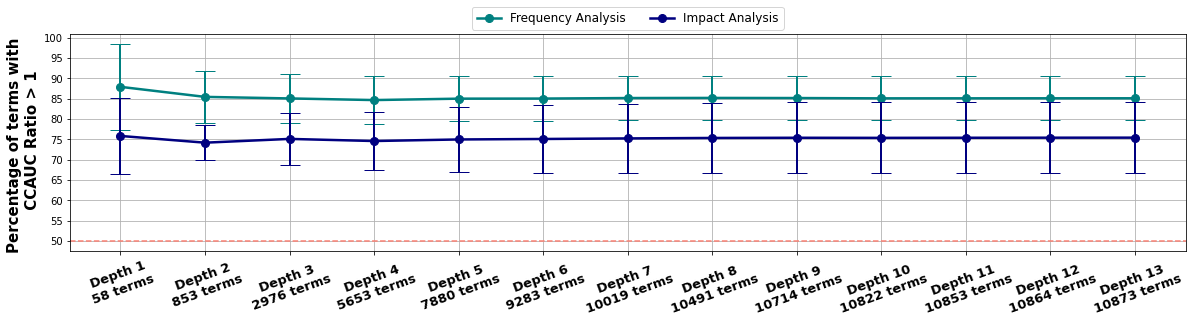

In [73]:
import matplotlib.pyplot as plt

x = ['Depth ' + str(each + 1) + '\n' + str(len(multi_level_duis_mcclags[each])) + ' terms' for each in range(len(greater_one_percentages))]

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')
line2, = ax.plot(x, max_window_freq_percents, marker='o', color='teal', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax.errorbar(x, max_window_freq_percents, yerr=[freq_std, freq_error_max], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
line1, = ax.plot(x, max_window_imp_percents, marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax.errorbar(x, max_window_imp_percents, yerr=[imp_std, imp_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with \n CCAUC Ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=20, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 5))  # Set y-axis ticks from 50 to 100 in steps of 10

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.15), ncol=4)  # Add legend
plt.savefig('impact_vs_freq_CCAUC.png', dpi=300, bbox_inches='tight')
plt.show()

plotting together

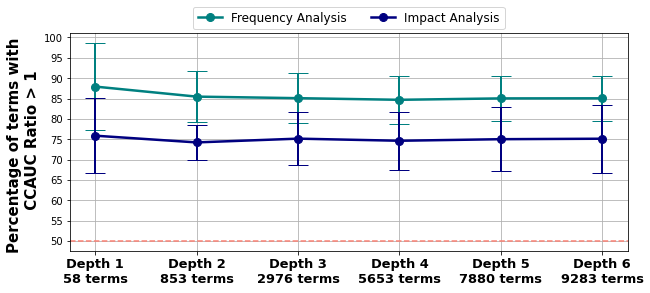

In [74]:
import matplotlib.pyplot as plt

chunk_size = 6
x = ['Depth ' + str(each + 1) + '\n' + str(len(multi_level_duis_mcclags[each])) + ' terms' for each in range(len(greater_one_percentages[:chunk_size]))]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')
line2, = ax.plot(x, max_window_freq_percents[:chunk_size], marker='o', color='teal', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax.errorbar(x, max_window_freq_percents[:chunk_size], yerr=[freq_std[:chunk_size], freq_error_max[:chunk_size]], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
line1, = ax.plot(x, max_window_imp_percents[:chunk_size], marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax.errorbar(x, max_window_imp_percents[:chunk_size], yerr=[imp_std[:chunk_size], imp_error_max[:chunk_size]], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with \n CCAUC Ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 5))  # Set y-axis ticks from 50 to 100 in steps of 10

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.15), ncol=4)  # Add legend
plt.savefig('impact_vs_freq_CCAUC.png', dpi=300, bbox_inches='tight')
plt.show()

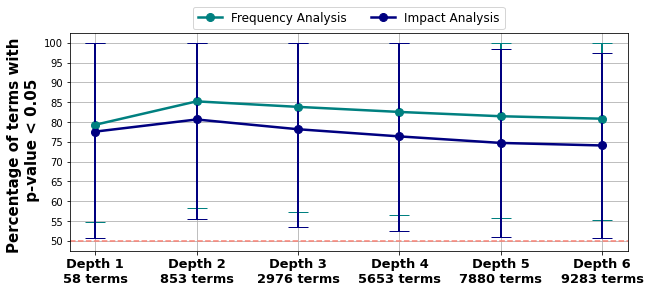

In [75]:
import matplotlib.pyplot as plt

chunk_size = 6
x = ['Depth ' + str(each + 1) + '\n' + str(len(multi_level_duis[each])) + ' terms' for each in range(len(depth_wise_chi2tests_maxlen[:chunk_size]))]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')
line2, = ax.plot(x, depth_wise_chi2tests_maxlen_freq[:chunk_size], marker='o', color='teal', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax.errorbar(x, depth_wise_chi2tests_maxlen_freq[:chunk_size], yerr=[depth_wise_chi2tests_std_freq[:chunk_size], chi2tests_freq_error_max[:chunk_size]], fmt='o', ecolor='teal', elinewidth=2, capsize=10, color='teal')
line4, = ax.plot(x, depth_wise_chi2tests_maxlen_imp[:chunk_size], marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax.errorbar(x, depth_wise_chi2tests_maxlen_imp[:chunk_size], yerr=[depth_wise_chi2tests_std_imp[:chunk_size], chi2tests_imp_error_max[:chunk_size]], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of terms with \n p-value < 0.05', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 5))  # Set y-axis ticks from 50 to 100 in steps of 10

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.15), ncol=4)  # Add legend
plt.savefig('impact_vs_freq_granger_causality.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1864593/14926576.py:19: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set_xticks([])  # Remove x-axis ticks for the top subplot


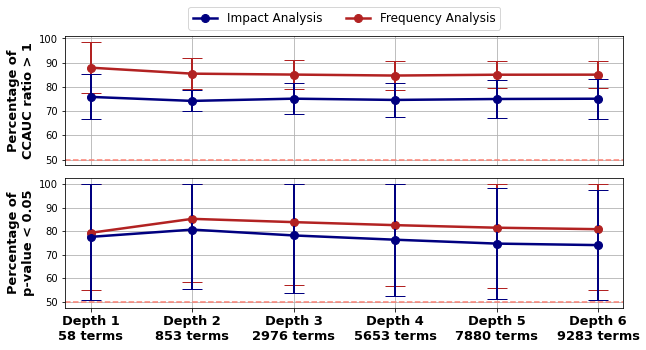

In [76]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Your existing data and plots for CCAUC...

# Create a 2x1 grid
fig = plt.figure(figsize=(10, 5), facecolor='white')
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)  # Set the height ratios and space between the subplots

# Top subplot for CCAUC
ax1 = fig.add_subplot(gs[0])
ax1.axhline(y=50, color='salmon', linestyle='--')
line2, = ax1.plot(x, max_window_freq_percents[:chunk_size], marker='o', color='firebrick', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax1.errorbar(x, max_window_freq_percents[:chunk_size], yerr=[freq_std[:chunk_size], freq_error_max[:chunk_size]], fmt='o', ecolor='firebrick', elinewidth=2, capsize=10, color='firebrick')
line1, = ax1.plot(x, max_window_imp_percents[:chunk_size], marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax1.errorbar(x, max_window_imp_percents[:chunk_size], yerr=[imp_std[:chunk_size], imp_error_max[:chunk_size]], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels([])  # Remove x-axis labels for the top subplot 
ax1.set_xticks([])  # Remove x-axis ticks for the top subplot
ax1.grid(True)  # Add gridlines
ax1.set_ylabel('Percentage of\nCCAUC ratio > 1', fontsize=13, weight='bold')
ax1.set_yticks(range(50, 101, 10))  # Set y-axis ticks from 50 to 100 in steps of 10
ax1.tick_params(axis='x', colors='white')  # Set the top x-axis tick labels color to white

# Bottom subplot for p-value
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Share the same x-axis with the top subplot
ax2.axhline(y=50, color='salmon', linestyle='--')
line2, = ax2.plot(x, depth_wise_chi2tests_maxlen_freq[:chunk_size], marker='o', color='firebrick', linewidth=2.5, markersize=8, label='Frequency Analysis')
ax2.errorbar(x, depth_wise_chi2tests_maxlen_freq[:chunk_size], yerr=[depth_wise_chi2tests_std_freq[:chunk_size], chi2tests_freq_error_max[:chunk_size]], fmt='o', ecolor='firebrick', elinewidth=2, capsize=10, color='firebrick')
line4, = ax2.plot(x, depth_wise_chi2tests_maxlen_imp[:chunk_size], marker='o', color='navy', linewidth=2.5, markersize=8, label='Impact Analysis')
ax2.errorbar(x, depth_wise_chi2tests_maxlen_imp[:chunk_size], yerr=[depth_wise_chi2tests_std_imp[:chunk_size], chi2tests_imp_error_max[:chunk_size]], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
ax2.grid(True)  # Add gridlines
ax2.set_ylabel('Percentage of\np-value < 0.05', fontsize=13, weight='bold')
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, fontsize=13, weight='bold')  # Set x-axis labels for the bottom subplot
ax2.set_yticks(range(50, 101, 10))  # Set y-axis ticks from 50 to 100 in steps of 10

# Create a combined legend for both subplots and position it at the top of the top subplot
combined_lines = [line1, line2]
combined_labels = [line.get_label() for line in combined_lines]
ax1.legend(combined_lines, combined_labels, loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.27), ncol=3)

# Save the plot or display it
plt.savefig('impact_vs_freq_combined.png', dpi=300, bbox_inches='tight')
plt.show()